
# House Price Prediction

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

Which variables are significant in predicting the price of a house, and

*   Which variables are significant in predicting the price of a house, and
*   How well those variables describe the price of a house.
*   Determine the optimal value of lambda for ridge and lasso regression.



## Import all the required modules

In [505]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [506]:
pd.set_option('display.max_columns', 50)

## Common Utility Methods

In [507]:
def summarize_missing_values(df):
  """
  Summarizes columns in a dataframe that has missing values.

  Args:
      df (pandas.DataFrame): The DataFrame to analyze.

  Returns:
      pandas.DataFrame: A DataFrame with columns 'Column Name', 'Missing Values', and 'percentMissing'.
  """
  # Filter for columns with null values
  df_with_null = df.columns[df.isna().any()]
  print(f"Following columns have null values: \n {df_with_null}\n")
  # Add count of missing values for each column and percentage of nulls missing
  # print only columns that have atleast a single missing columns
  result_df = df[df_with_null].isna().agg(lambda x: x.sum(), axis=0) \
              .rename_axis('Column Name') \
              .reset_index(name='Missing Values') \
              .assign(percentMissing=lambda x: (x['Missing Values'] / len(df)) * 100).round({'percentMissing': 2}) \
              .sort_values(by='percentMissing', ascending=False)
  result_df.reset_index(inplace=True, drop=False)
  print(result_df)

In [508]:
def get_correlated_columns(df, threshold=0.60):
  """
  This function finds column pairs in a DataFrame with correlation greater than a threshold.

  Args:
      df: The pandas DataFrame to analyze.
      threshold: The minimum correlation coefficient (absolute value) to consider.

  Returns:
      A list of tuples containing the column names and their correlation coefficient.
  """
  correlation_matrix = df.corr()
  correlated_pairs = []

  # Iterate the upper triangle of the correlation matrix (excluding diagonal)
  for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
      # We should only process upper triangle and avoid self-correlation
      if col1 != col2 and col1 > col2:
        correlation_value = correlation_matrix.loc[col1, col2]
        # Check for absolute correlation greater than the threshold
        if abs(correlation_value) > threshold:
          correlated_pairs.append((col1, col2, correlation_value))

  return correlated_pairs

In [509]:
def print_correlated_column_pairs_with_corr_value(df, threshold=0.60):
  """
  This function uses get_correlated_columns() and finds and
  prints column pairs in a DataFrame with correlation greater than a threshold.

  Args:
      df: The pandas DataFrame to analyze.
      threshold: The minimum correlation coefficient (absolute value) to consider.

  Returns:
      A list of tuples containing the column names and their correlation coefficient.
  """
  numerical_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
  numerical_cols.remove('SalePrice') #Removing target variable
  correlated_pairs = get_correlated_columns(house[numerical_cols], threshold)

  if correlated_pairs:
    print("Correlated column pairs (absolute correlation > 0.60):")
    for pair in correlated_pairs:
      print(f"- {pair[0]} with {pair[1]}: {pair[2]:.2f}")
  else:
    print("No column pairs found with correlation greater than 0.60")

In [510]:
def get_outlier_stats(df):
  """
  Calculates the sum and percentage of outliers in each numerical column of a DataFrame.

  Args:
      df: The pandas DataFrame containing numerical columns.

  Returns:
      A DataFrame with outlier sum, percentage, total data points, and IQR for each column.
  """

  outlier_stats = pd.DataFrame(columns=['outlier_sum', 'outlier_pct', 'total_count', 'iqr'])
  for col in df.select_dtypes(include='number'):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    # inter quantile range
    iqr = q3 - q1
    # Lower and upper bounds for outliers (1.5 IQR from quartiles)
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)

    # Calculating outlier sum and percentage
    outlier_sum = outliers[col].sum() if not outliers.empty else 0
    outlier_pct = (outlier_count / len(df)) * 100 if len(df) > 0 else 0
    outlier_stats.loc[col] = [outlier_sum, outlier_pct, len(df), iqr]

  return outlier_stats.sort_values(by='outlier_pct', ascending=False)

In [511]:
def scatter_plot_all_numerics_grid(df, target_col, rows=9, cols=3, figsize=(24, 24), hspace=2.0):
  """
  Creates a grid of scatter plots for all numerical columns in a DataFrame
  against a target column.

  Args:
      df: The pandas DataFrame containing numerical columns and the target column.
      target_col: The name of the target column.
      rows (int, optional): The number of rows in the grid of subplots. Defaults to 9.
      cols (int, optional): The number of columns in the grid of subplots. Defaults to 3.
      figsize (tuple, optional): The size of the figure in inches. Defaults to (24, 24).
      hspace (float, optional): The horizontal spacing between subplots. Defaults to 2.0.
  """

  # Filter numerical columns (excluding the target column and Id)
  numeric_cols = df.select_dtypes(include='number').columns.tolist()
  numeric_cols.remove('Id')
  numeric_cols.remove(target_col)
  #print(numeric_cols)
  #print(len(numeric_cols))

  fig, axes = plt.subplots(rows, cols, figsize=figsize)
  axes_flat = axes.ravel()
  for i, col in enumerate(numeric_cols):
    plt.subplot(14, 2, i+1)
    sns.scatterplot(x=df[col], y=df[target_col])
    axes_flat[i].set_xlabel(col)
    axes_flat[i].set_ylabel(target_col)
    print(i,col)

  plt.subplots_adjust(hspace=hspace)

  # Show the plots
  plt.show()

In [512]:
def analyze_column_against_count(df, column_name):
  """
    The below function performs univariate analysis on a column in a DataFrame
    by first checking for data type of whether its numerical type or categorical type
    abd create plots

    For the numerical data, it plots the distribution with KDE curve, histogram,
    boxplot and also indicates the mean

    For the categorical variable, it plots the box and bar plot against the SalePrice.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        column (str): The name of the column to analyze.

    Returns:
        None
  """
  fig, axes = plt.subplots(1, 2, figsize=(16, 4), dpi=100)
  # Check data type
  if pd.api.types.is_numeric_dtype(df[column_name]):
    # Numerical data - Create box plot
    median = df[column_name].median()
    plt.xlabel(column_name)
    axes[0].axvline(median, color="green", linestyle="--", label=f"Median: {median:.2f}")
    axes[0].legend()
    sns.distplot(df[column_name], kde=True, hist=True, ax=axes[0], label=True)
    axes[0].set_title(f"Distribution with KDE and Histogram for {column_name}")
    sns.boxplot(x = column_name, showmeans=True, data=df, ax=axes[1])
    plt.title("Box Plot of " + column_name)
  else:
    # Categorical data - Create box plot
    axes[0].set_title("Box Plot of SalePrice by " + column_name)
    sns.boxplot(x = column_name, y='SalePrice', showmeans=True, data=df, ax=axes[0])

    # Bar plot with legend based on hue
    sns.barplot(x = column_name, y='SalePrice', data=df, ax=axes[1])
    handles, labels = axes[1].get_legend_handles_labels()  # Get legend elements

    # Create custom legend with colors corresponding to years
    by_label = dict(handles)
    #axes[1].legend(by_label.values(), by_label.keys(), title="Year")  # Set legend with colors and labels
    axes[1].set_title("Bar chart of SalePrice by " + column_name)

  plt.show()

In [513]:
def print_vif_data(dataset: pd.DataFrame) -> None:
    """
    Prints a DataFrame containing feature names and their respective VIFs, sorted in descending VIF order.

    Args:
        dataset (pd.DataFrame): The dataset containing the features.

    Returns:
        None (prints the DataFrame to the console)
    """

    # Create a DataFrame to store VIF values
    vif_df = pd.DataFrame({'Features': dataset.columns})

    # Calculate VIF for each feature
    vif_df['VIF'] = [variance_inflation_factor(dataset.values, i) for i in range(dataset.shape[1])]
    vif_df['VIF'] = vif_df['VIF'].round(2)
    #print sorted result
    print(vif_df.sort_values(by='VIF', ascending=False))

## Regularization Class to handle Ridge and Lasso Regressions with metrics

In [514]:
class RegularizedLinearRegression:
  """
  - Performs hyperparameter tuning and fitting for ridge or lasso regression.
  - Public method that as a print method that prints the regression results
  - Public method that plots model scores vs the alpha values used in grid search computation

  Attributes:
      model_name (str): Name of the model ("ridge" or "lasso").
      best_model (object): Best model found by GridSearchCV.
      best_alpha (float): Best alpha value for the model.
      r2_train (float): R-squared score on training data.
      r2_test (float): R-squared score on testing data.
      mse_train (float): Mean squared error on training data.
      mse_test (float): Mean squared error on testing data.
      coef_ (ndarray): Model coefficients.
  """

  def __init__(self, X_train, y_train, X_test, y_test, model_name="ridge", alpha=None):
    """
    Initializes the class with training and testing data and model name.

    Args:
        X_train (pandas.DataFrame): Training data features.
        y_train (pandas.Series): Training data target variable.
        X_test (pandas.DataFrame): Testing data features.
        y_test (pandas.Series): Testing data target variable.
        model_name (str, optional): Model name ("ridge" or "lasso"). Defaults to "ridge".
    """

    self.model_name = model_name.lower()  # Ensure lowercase model name
    self.best_model = None
    self.best_alpha = None
    self.r2_train = None
    self.r2_test = None
    self.rss_train = None
    self.rss_test = None
    self.mse_train = None
    self.mse_test = None
    self.coef_ = None
    self.cv_results = None
    self.alpha = alpha

    self._find_best_alpha(X_train, y_train, X_test, y_test)

  def _find_best_alpha(self, X_train, y_train, X_test, y_test):
    """
    Finds the best alpha value and fits the model.

    Private method to avoid code duplication.
    """

    if self.model_name == "ridge":
      model = Ridge()
    elif self.model_name == "lasso":
      model = Lasso()
    else:
      raise ValueError("Invalid model name. Choose 'ridge' or 'lasso'.")

    if self.alpha is not None:
      params = {'alpha' : [self.alpha]}
    else:
    # 32 alpha params, meaning 32 candidates for getting the best model
      params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                      1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0,
                      10.0, 20, 50, 100, 200, 300, 400, 500, 1000 ]}
    # Create GridSearchCV object
    #grid_search = GridSearchCV(model, param_grid=params, cv=5)
    folds = 5
    grid_search = GridSearchCV(estimator = model,
                            param_grid = params,
                            scoring= 'neg_mean_absolute_error',
                            cv = folds,
                            return_train_score=True,
                            verbose = 1)
    grid_search.fit(X_train, y_train)

    self.best_model = grid_search.best_estimator_
    self.best_alpha = grid_search.best_params_["alpha"]
    self.cv_results = grid_search.cv_results_

    self.best_model.fit(X_train, y_train)
    y_train_pred = self.best_model.predict(X_train)
    y_test_pred = self.best_model.predict(X_test)

    self.r2_train = r2_score(y_train, y_train_pred)
    self.r2_test = r2_score(y_test, y_test_pred)

    residuals = y_train - y_train_pred  # Calculate residuals (errors)
    self.rss_train = np.sum(residuals**2)  # Square residuals and sum them
    residuals = y_test - y_test_pred  # Calculate residuals (errors)
    self.rss_test = np.sum(residuals**2)  # Square residuals and sum them

    self.mse_train = mean_squared_error(y_train, y_train_pred)
    self.mse_test = mean_squared_error(y_test, y_test_pred)
    self.coef_ = self.best_model.coef_.ravel()  # Model coefficients

  def PrintRegressionResults(self):
    """
    Prints summary metrics of the values computed by the specified model.

    Public method to encapsulate metrics and coefficients determined previously during object construction.
    """
    # Print the results
    print(f"** {self.model_name} Regression Results **")
    print(f"Best Alpha: {self.best_alpha:.4f}")
    print(f"Training R-squared: {self.r2_train:.4f}")
    print(f"Testing R-squared: {self.r2_test:.4f}")
    print(f"Training Residual Sum of Squares (RSS): {self.rss_train:.4f}")
    print(f"Testing Residual Sum of Squares (RSS): {self.rss_test:.4f}")
    print(f"Training Mean Squared Error: {self.mse_train:.4f}")
    print(f"Testing Mean Squared Error: {self.mse_test:.4f}")
    print(f"Coefficients:\n{self.coef_}")

  def Plot_alpha_vs_mean_scores(self, skip=-2):
    """
    Plots model scores vs the alpha values used in grid search computation

    Args:
      To plot effectively, provide an optional skip to skip elements
    """
    mean_train_scores = self.cv_results["mean_train_score"][:skip]
    mean_test_scores = self.cv_results["mean_test_score"][:skip]
    # Invert scores (for plotting as maximization problem)
    mean_train_scores = -mean_train_scores
    mean_test_scores = -mean_test_scores
    alpha_range = self.cv_results['param_alpha'].astype('float64')[:skip]

    # Plot alpha vs mean scores
    plt.plot(alpha_range, mean_train_scores, label="Training Score")
    plt.plot(alpha_range, mean_test_scores, label="Test Score")

    # Label and title the plot
    plt.xlabel("Alpha")
    plt.ylabel("Mean Squared Error (Lower is better)")  # Assuming MSE metric
    plt.title(f"{self.model_name} Model Scores vs Alpha")
    plt.legend()
    plt.grid(True)
    plt.show()

In [515]:
def RegressionMetricsPrinter (linear_model, ridge_model, lasso_model):
    """
    Prints summary metrics of the metrics values passed for Linear, Ridge and Lasso Regression

    Args:
      Expectes the model parameters to be having all the properties defined in RegularizedLinearRegression class

    Returns:
      Nothing
    """
    df = pd.DataFrame(columns =['Metric', 'Linear Regression', 'Ridge Regression', 'Lasso Regression'])
    df['Metric'] = ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)', 'MSE (Train)','MSE (Test)']
    df['Linear Regression'] = [linear_model.r2_train, linear_model.r2_test, linear_model.rss_train, linear_model.rss_test, linear_model.mse_train, linear_model.mse_test ]
    df['Ridge Regression'] = [ridge_model.r2_train, ridge_model.r2_test, ridge_model.rss_train, ridge_model.rss_test, ridge_model.mse_train, ridge_model.mse_test ]
    df['Lasso Regression'] = [lasso_model.r2_train, lasso_model.r2_test, lasso_model.rss_train, lasso_model.rss_test, lasso_model.mse_train, lasso_model.mse_test ]

    print(df)

## Exploratory Data Analysis (EDA)

In [516]:
# load the data
house = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/01. Assignments/1. Housing_Assignment/train.csv")
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,...,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,...,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,...,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,...,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [517]:
house.shape

(1460, 81)

There are 1460 Rows of data for 81 Columns

In [518]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


### Handle Missing or Null Data

In [519]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [520]:
summarize_missing_values(house)

Following columns have null values: 
 Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

    index   Column Name  Missing Values  percentMissing
0      16        PoolQC            1453           99.52
1      18   MiscFeature            1406           96.30
2       1         Alley            1369           93.77
3      17         Fence            1179           80.75
4       2    MasVnrType             872           59.73
5      10   FireplaceQu             690           47.26
6       0   LotFrontage             259           17.74
7      11    GarageType              81            5.55
8      12   GarageYrBlt              81            5.55
9      13  GarageFinish              81            5.55
10     14    GarageQual    

We can note from above that only 19 columns out of 81 independent variables have null values and even in those only 6 of them have more than 40% null values. We cannot simply remove those. Lets analyse if we can impute them that makes sense.

In [521]:
# Lets Analyse the type of each of the 6 columns and if it is really need to be removed
house[['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PoolQC       7 non-null      object
 1   MiscFeature  54 non-null     object
 2   Alley        91 non-null     object
 3   Fence        281 non-null    object
 4   MasVnrType   588 non-null    object
 5   FireplaceQu  770 non-null    object
dtypes: object(6)
memory usage: 68.6+ KB


1. PoolQC: Pool quality with null value could indicate Non availability of data for quality of pool or pool itself not available. Further it has a dependency with PoolArea field and examine its collinearity with Poolarea and if most of the houses doesn't have pools or the quality of pools it could be removed.
2. MiscFeature: Miscellaneous feature not covered in other categories indicates None, So it can be mapped to Not Available
3. Alley:  Null or NA could be the same
4. Fense: Null values could indicate no Fence
5. MasVnrType: This is Masonry Veneer Type, We could map it to existing None
6. FireplaceQu: Fireplace Quality, non availability of data could mean no Fireplace, so it can be mapped

Conclusion: Therefore, from the above List, we could consider for remove PoolQC from analysis. Lets examine PoolQC collinear with PoolArea


#### PoolArea Vs PoolQC

In [522]:
house['PoolQC'].value_counts()

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64

In [523]:
house['PoolQC'].fillna("NA", inplace=True)

In [524]:
house['PoolQC'].value_counts()

PoolQC
NA    1453
Gd       3
Ex       2
Fa       2
Name: count, dtype: int64

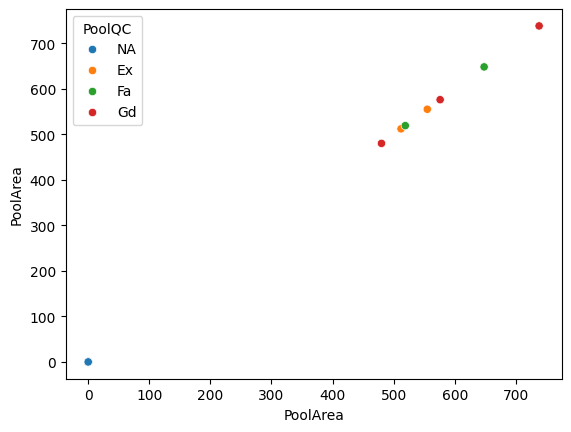

In [525]:
sns.scatterplot(
    x = "PoolArea",
    y = "PoolArea",
    hue = "PoolQC",
    data=house
)
plt.show()

Conclusion: Therefore, from above data, we can see collinearity between PoolArea and PoolQC, and further we can see those classifications are based on the pool size. therefore Its worth to remove PoolQC

In [526]:
house.drop('PoolQC', axis=1, inplace=True)
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,...,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,...,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,...,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,...,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,...,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,...,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,0,12,2008,WD,Normal,250000


#### Evaluate other Object types with nulls

In [527]:
# Lets create an array to track columns with nulls
columns_with_nulls = ['MasVnrType','LotFrontage', 'Alley', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt','GarageFinish', 'GarageQual', 'GarageCond', 'Fence','MiscFeature']

In [528]:
object_cols_with_nulls = house[columns_with_nulls].select_dtypes(include='object').columns.tolist()
numerical_cols_with_nulls = house[columns_with_nulls].select_dtypes(include='float64').columns.tolist()

In [529]:
house[object_cols_with_nulls].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MasVnrType    588 non-null    object
 1   Alley         91 non-null     object
 2   BsmtQual      1423 non-null   object
 3   BsmtCond      1423 non-null   object
 4   BsmtExposure  1422 non-null   object
 5   BsmtFinType1  1423 non-null   object
 6   BsmtFinType2  1422 non-null   object
 7   Electrical    1459 non-null   object
 8   FireplaceQu   770 non-null    object
 9   GarageType    1379 non-null   object
 10  GarageFinish  1379 non-null   object
 11  GarageQual    1379 non-null   object
 12  GarageCond    1379 non-null   object
 13  Fence         281 non-null    object
 14  MiscFeature   54 non-null     object
dtypes: object(15)
memory usage: 171.2+ KB


On analysing each of the following with data dictionary (data_secription file) following could be substituted with a string NA instead of dropping the columns alltogether:
0. MasVnrType: We have already decided to map it to Existing None
1. Alley:  NA means No alley access
2. BsmtQual: NA	means No Basement
3. BsmtCond: NA	means No Basement
4. BsmtExposure: NA	means No Basement
5. BsmtFinType1: NA	means No Basement
6. BsmtFinType2: NA	means No Basement
7. FireplaceQu: NA	means No Fireplace
8. GarageFinish: NA means No Garage
9. GarageQual: NA means No Garage
10. GarageCond: NA means No Garage
11. Fence: NA means No Fence       
13. MiscFeature: NA means No other special features available in the property

**For Following columns Remove Rows since we cannot substitute with appropriate value as it doesn't make sense and low missing value count:**

**Electrical**: Electrical System type is required for a house, since just one missing count we can remove the row


In [530]:
house['MasVnrType'].value_counts()

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

Therefore, not harm in mapping it to NA similar to other types

##### Substitute analysed object columns with "NA"

In [531]:
object_cols_with_nulls.remove('Electrical')

In [532]:
for object_col in object_cols_with_nulls:
  house[object_col] = house[object_col].fillna("NA")

##### Remove row for Electrical that has a null value

We do this since there is only only row

In [533]:
house = house.dropna(subset=['Electrical'])

In [534]:
house.shape

(1459, 80)

#### Evaluate Numerical Columns with Nulls

In [535]:
house[numerical_cols_with_nulls].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1200 non-null   float64
 1   MasVnrArea   1451 non-null   float64
 2   GarageYrBlt  1378 non-null   float64
dtypes: float64(3)
memory usage: 45.6 KB


In [536]:
summarize_missing_values(house)

Following columns have null values: 
 Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

   index  Column Name  Missing Values  percentMissing
0      0  LotFrontage             259           17.75
1      2  GarageYrBlt              81            5.55
2      1   MasVnrArea               8            0.55


From above data, we can infer from the dictionary as follows:
1. LotFrontage: Linear feet of street connected to property. Due to 19% missing for this, it makes sense to drop this column
2. GarageYrBlt: Year garage was built. Lets analyse the collinearity of this column with YearBuilt and determine using a plot and correlation value, so one of it could be dropped
3. MasVnrArea: Masonry veneer area in square feet: Only 8 missing rows, so similar to Electrical column, we can just remove the rows corresponding to this null values

In [537]:
house.drop('LotFrontage', axis=1, inplace=True)

##### GarageYrBlt vs YearBuilt

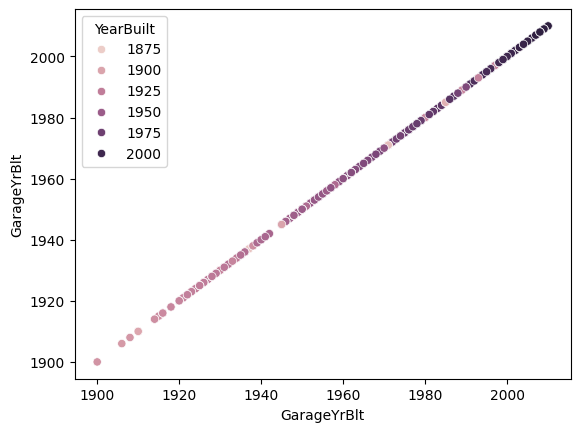

0.8255032711686539


In [538]:
sns.scatterplot(
    x = "GarageYrBlt",
    y = "GarageYrBlt",
    hue = "YearBuilt",
    data=house
)
plt.show()
print(house['GarageYrBlt'].corr(house['YearBuilt']))

Therefore From above it is very clear of collinearity and we don't want multi-collinearity among feature variables, so lets drop GarageYrBlt.

In [539]:
house.drop('GarageYrBlt', axis=1, inplace=True)

In [540]:
house = house.dropna(subset=['MasVnrArea'])

In [541]:
summarize_missing_values(house)

Following columns have null values: 
 Index([], dtype='object')

Empty DataFrame
Columns: [index, Column Name, Missing Values, percentMissing]
Index: []


From above, it is clear we don't have any missing values. Lets confirm further below using info command

In [542]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1451 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1451 non-null   int64  
 1   MSSubClass     1451 non-null   int64  
 2   MSZoning       1451 non-null   object 
 3   LotArea        1451 non-null   int64  
 4   Street         1451 non-null   object 
 5   Alley          1451 non-null   object 
 6   LotShape       1451 non-null   object 
 7   LandContour    1451 non-null   object 
 8   Utilities      1451 non-null   object 
 9   LotConfig      1451 non-null   object 
 10  LandSlope      1451 non-null   object 
 11  Neighborhood   1451 non-null   object 
 12  Condition1     1451 non-null   object 
 13  Condition2     1451 non-null   object 
 14  BldgType       1451 non-null   object 
 15  HouseStyle     1451 non-null   object 
 16  OverallQual    1451 non-null   int64  
 17  OverallCond    1451 non-null   int64  
 18  YearBuilt    

We now have a clean data dataset with no missing values on all features

###EDA on Numerical Data

##### Correlation Analysis of Numerical Feature Variables

In [543]:
numerical_cols = house.select_dtypes(include=['int64','float64']).columns.tolist()
numerical_cols.remove('SalePrice') #Removing target variable
correlationMatrix = house[numerical_cols].corr()

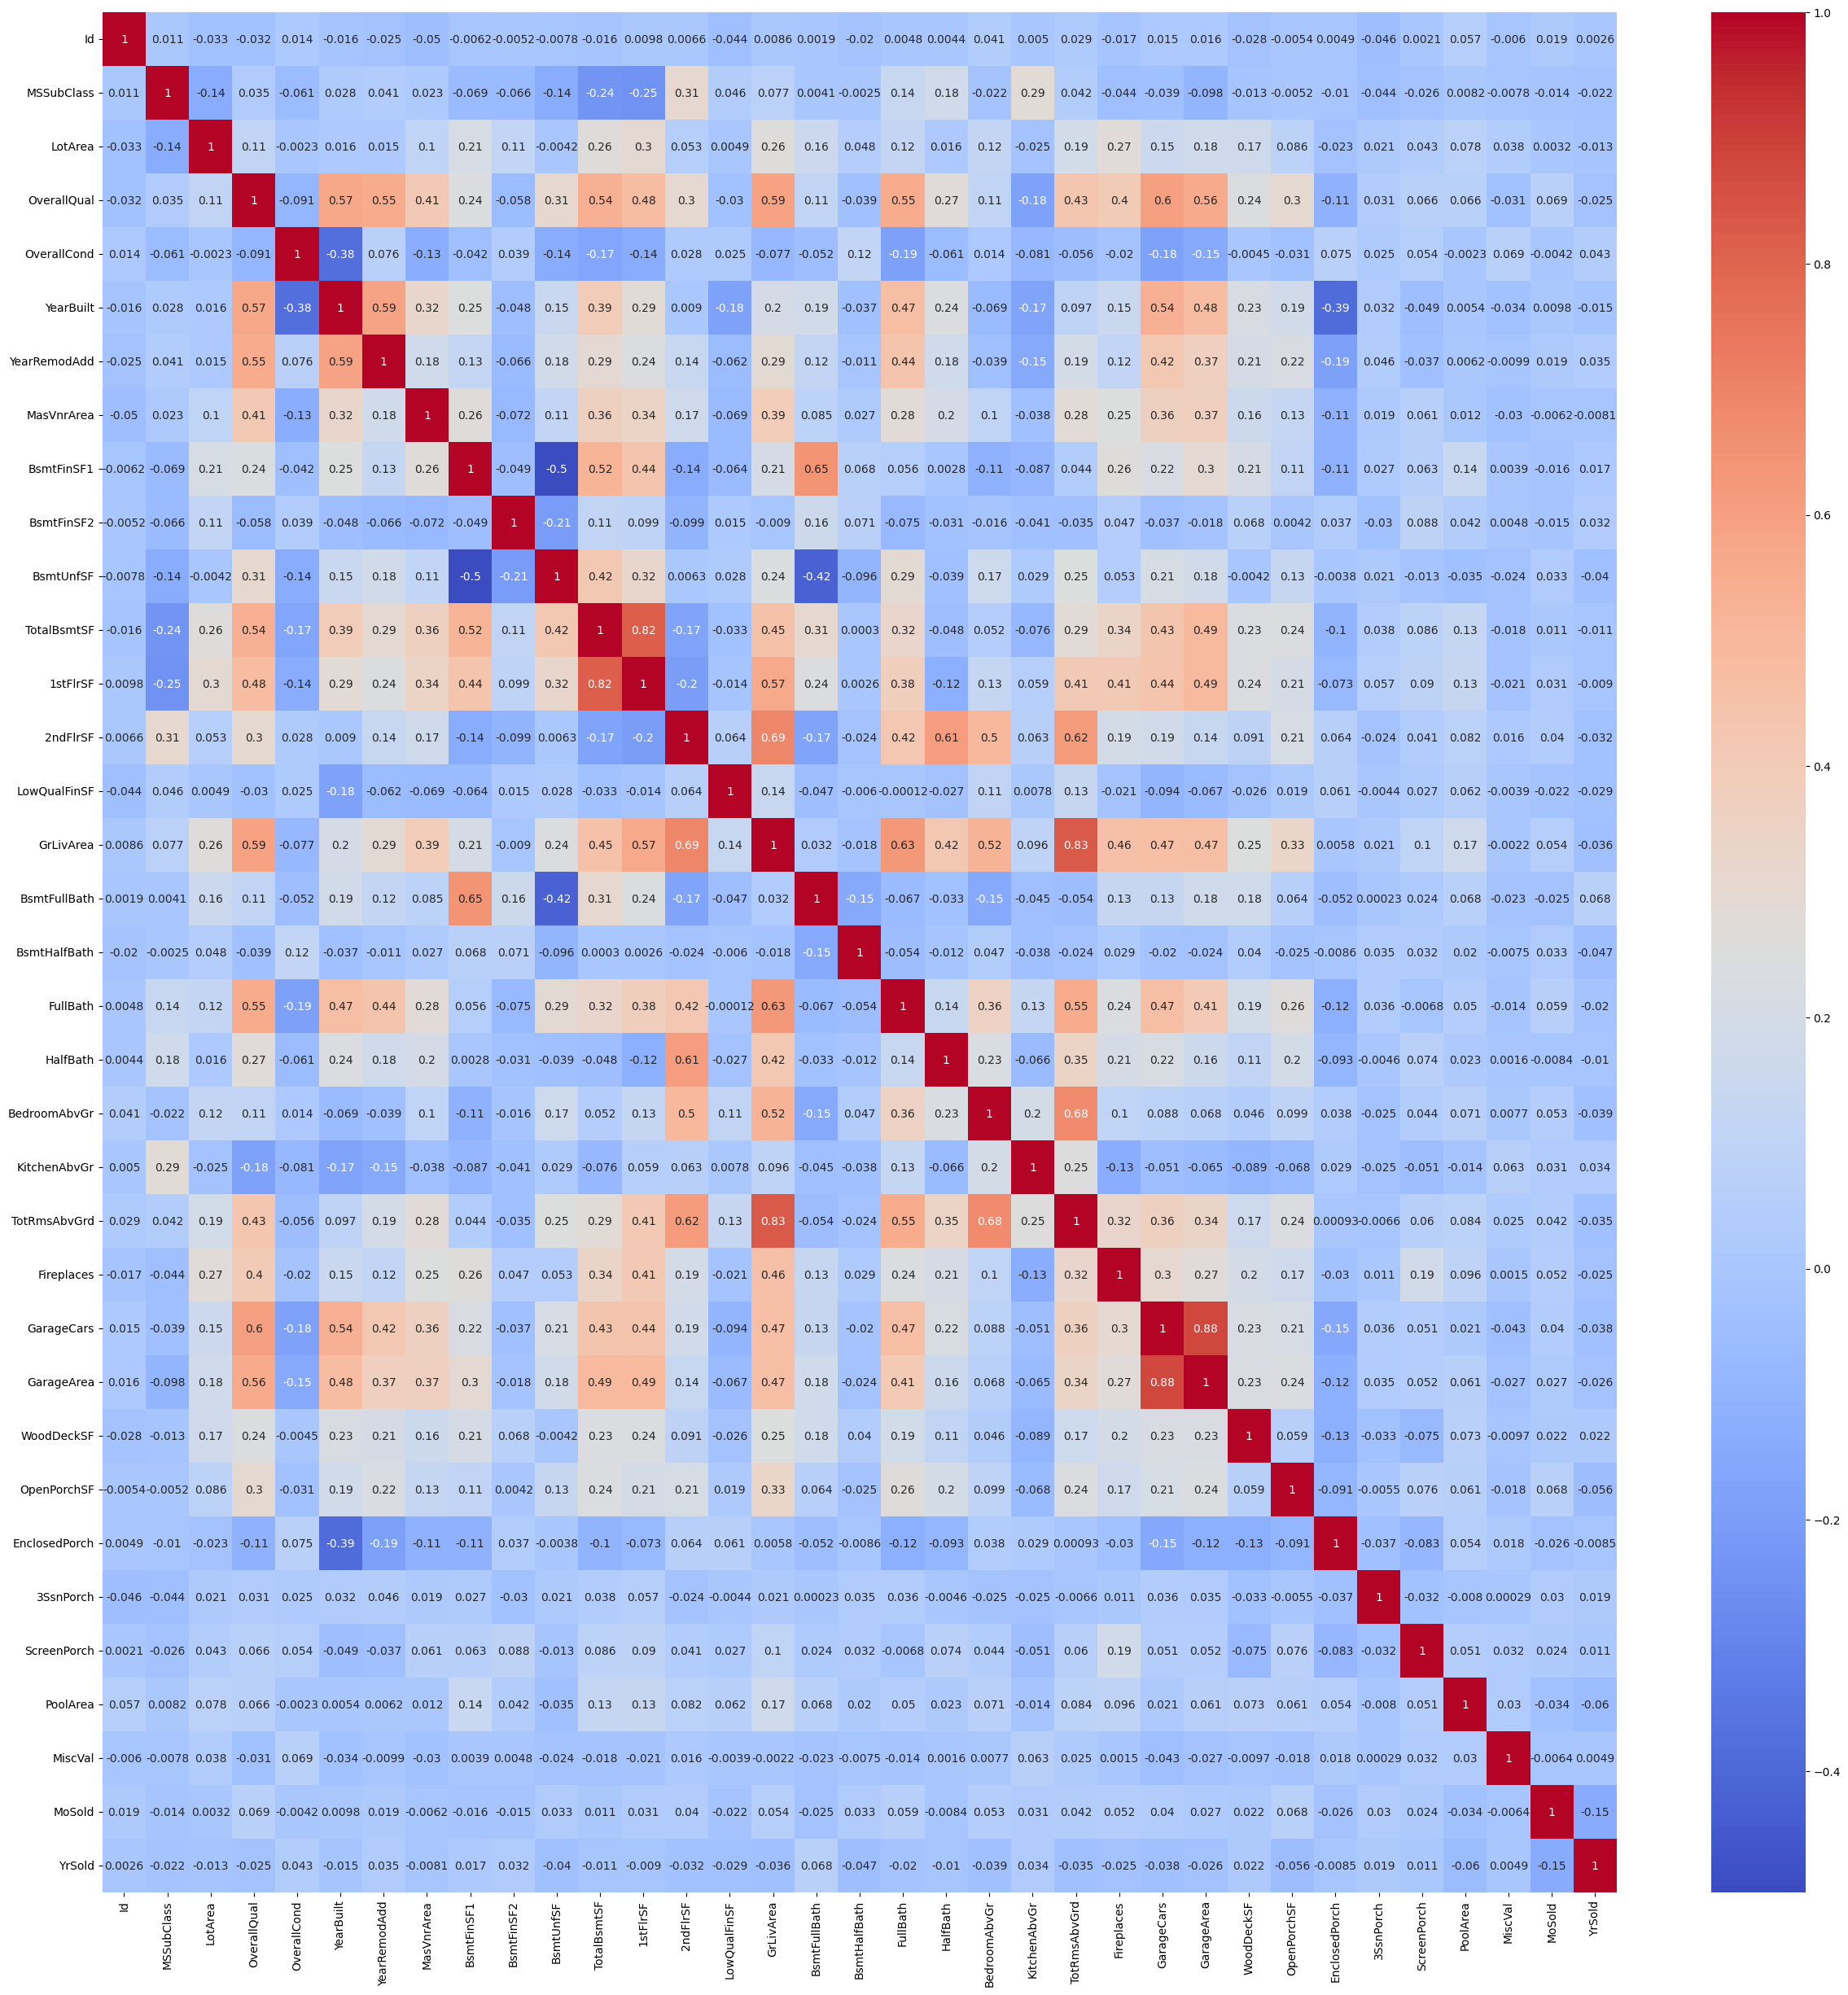

In [544]:
#print(correlationMatrix)
plt.figure(figsize=(30, 30))
hm = sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm')
plt.show()

We could observe multi-collinearity between feature variables. This will lead to High Variance in the estimated coefficients. So we need to remove one of them in each collinearity pair.

In [545]:
# Get all column pairs that have high correlation between them
print_correlated_column_pairs_with_corr_value(house)

Correlated column pairs (absolute correlation > 0.60):
- OverallQual with GarageCars: 0.60
- TotalBsmtSF with 1stFlrSF: 0.82
- GrLivArea with 2ndFlrSF: 0.69
- GrLivArea with FullBath: 0.63
- BsmtFullBath with BsmtFinSF1: 0.65
- HalfBath with 2ndFlrSF: 0.61
- TotRmsAbvGrd with 2ndFlrSF: 0.62
- TotRmsAbvGrd with GrLivArea: 0.83
- TotRmsAbvGrd with BedroomAbvGr: 0.68
- GarageCars with GarageArea: 0.88


On analysing the above feature columns that have high collinearity between them we need to decide on which one to remove and the reason as follows:
1. GargeCars: Since it not only have collinearity with OverallQual but also with GarageArea.
2. 1stFlrSF: Since basmentSF already has the ceiling sqft. included
3. 2ndFlrSF: since it has multicollineartity with others as well
4. GrLivArea : since it has multicollineartity with others as well
5. BsmtFullBath
6. BedroomAbvGr

In [546]:
house.drop(['GarageCars','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BedroomAbvGr'], axis=1, inplace=True)
house.shape

(1451, 72)

In [547]:
print_correlated_column_pairs_with_corr_value(house)

No column pairs found with correlation greater than 0.60


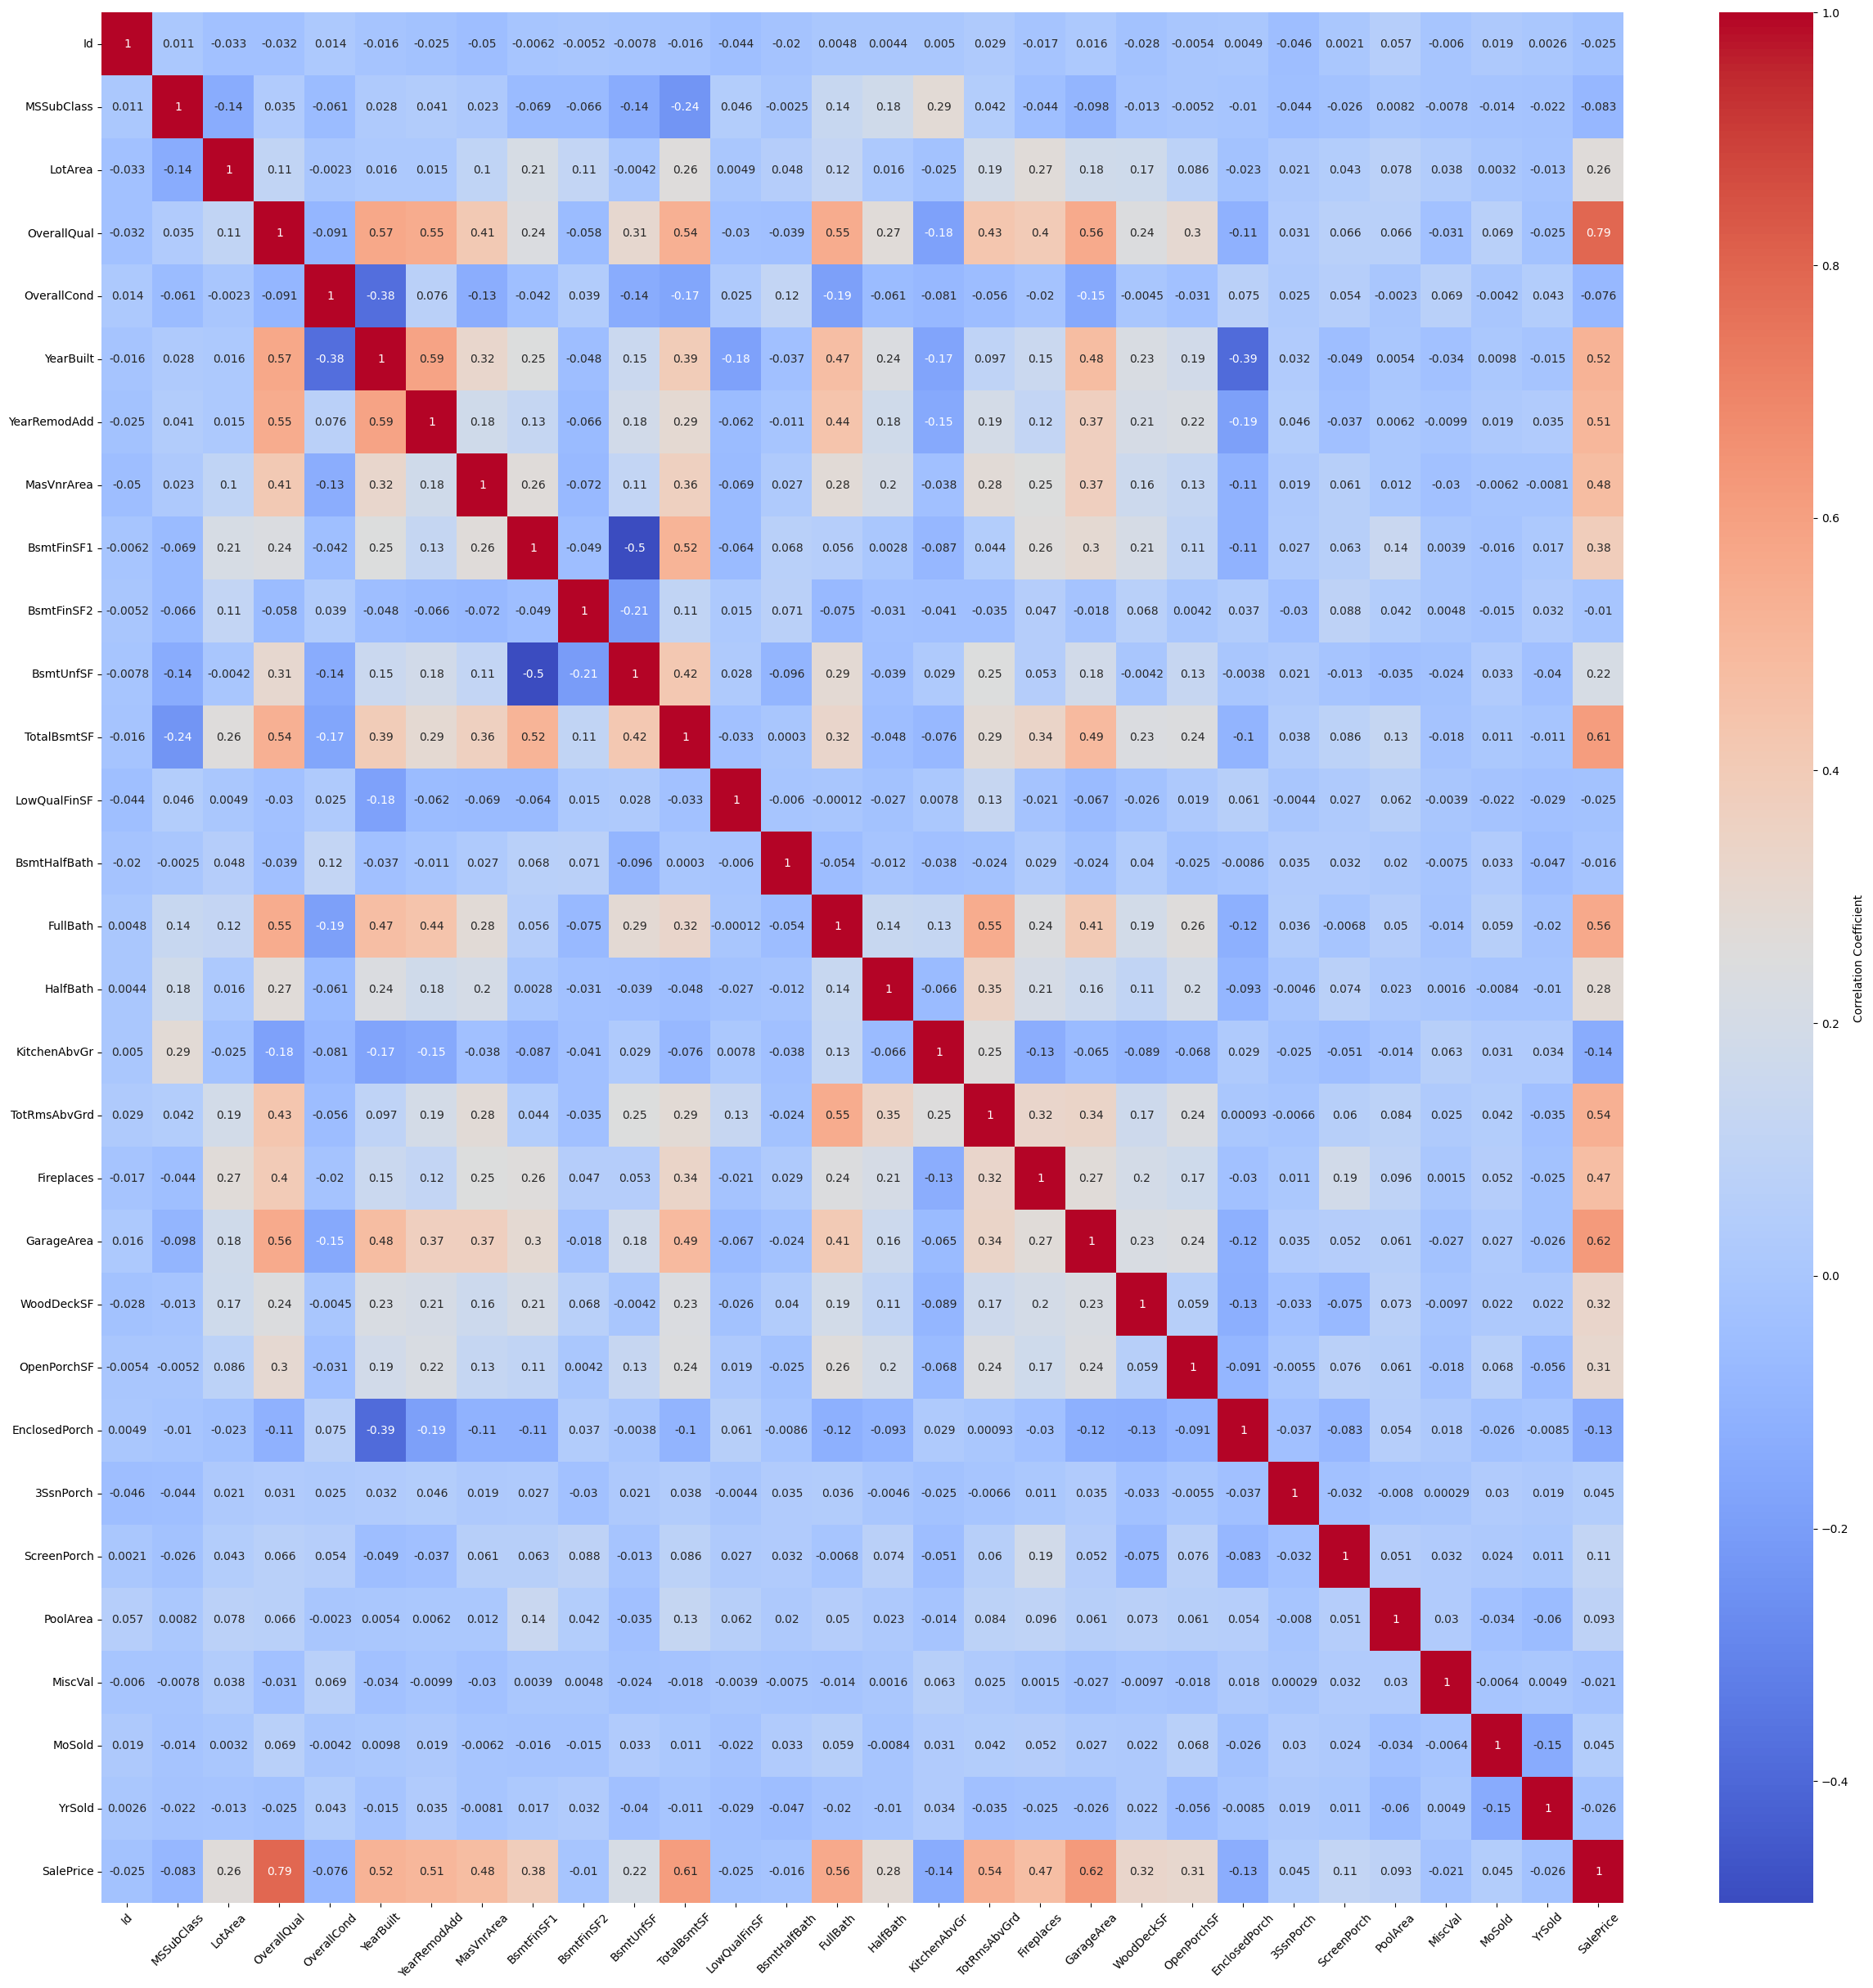

In [548]:
numerical_cols = house.select_dtypes(include=['int64','float64']).columns.tolist()
correlationMatrix = house[numerical_cols].corr();
plt.figure(figsize = (30, 30))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', xticklabels=correlationMatrix.columns, cbar_kws={"label": "Correlation Coefficient"})
plt.xticks(rotation=45)
plt.show()

The above correlation matrix looks great without any multi-collinearity issue between feature variables (those except the target variable 'SalePrice').

In [549]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1451 entries, 0 to 1459
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1451 non-null   int64  
 1   MSSubClass     1451 non-null   int64  
 2   MSZoning       1451 non-null   object 
 3   LotArea        1451 non-null   int64  
 4   Street         1451 non-null   object 
 5   Alley          1451 non-null   object 
 6   LotShape       1451 non-null   object 
 7   LandContour    1451 non-null   object 
 8   Utilities      1451 non-null   object 
 9   LotConfig      1451 non-null   object 
 10  LandSlope      1451 non-null   object 
 11  Neighborhood   1451 non-null   object 
 12  Condition1     1451 non-null   object 
 13  Condition2     1451 non-null   object 
 14  BldgType       1451 non-null   object 
 15  HouseStyle     1451 non-null   object 
 16  OverallQual    1451 non-null   int64  
 17  OverallCond    1451 non-null   int64  
 18  YearBuilt    

In [550]:
print(house.head(10))

   Id  MSSubClass MSZoning  LotArea Street Alley LotShape LandContour  \
0   1          60       RL     8450   Pave    NA      Reg         Lvl   
1   2          20       RL     9600   Pave    NA      Reg         Lvl   
2   3          60       RL    11250   Pave    NA      IR1         Lvl   
3   4          70       RL     9550   Pave    NA      IR1         Lvl   
4   5          60       RL    14260   Pave    NA      IR1         Lvl   
5   6          50       RL    14115   Pave    NA      IR1         Lvl   
6   7          20       RL    10084   Pave    NA      Reg         Lvl   
7   8          60       RL    10382   Pave    NA      IR1         Lvl   
8   9          50       RM     6120   Pave    NA      Reg         Lvl   
9  10         190       RL     7420   Pave    NA      Reg         Lvl   

  Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType  \
0    AllPub    Inside       Gtl      CollgCr       Norm       Norm     1Fam   
1    AllPub       FR2       Gtl      V

##### Outlier analysis of Numerical Data

In [551]:
outlier_stats = get_outlier_stats(house.copy())
print(outlier_stats)

               outlier_sum  outlier_pct  total_count      iqr
EnclosedPorch      31853.0    14.266023       1451.0      0.0
BsmtFinSF2         67962.0    11.509304       1451.0      0.0
OverallCond          857.0     8.545830       1451.0      1.0
ScreenPorch        21989.0     7.994487       1451.0      0.0
MSSubClass         17580.0     7.098553       1451.0     50.0
MasVnrArea         59432.0     6.616127       1451.0    166.0
BsmtHalfBath          84.0     5.651275       1451.0      0.0
OpenPorchSF        18573.0     5.168849       1451.0     68.0
LotArea          2422325.0     4.617505       1451.0   4062.5
KitchenAbvGr         134.0     4.617505       1451.0      0.0
TotalBsmtSF        59201.0     4.135079       1451.0    502.5
SalePrice       25518205.0     4.135079       1451.0  84100.0
MiscVal            63494.0     3.583735       1451.0      0.0
WoodDeckSF         16999.0     2.205376       1451.0    168.0
TotRmsAbvGrd         344.0     2.067540       1451.0      2.0
BsmtUnfS

**Inference:**

We can see that except a few most of them have outliers. But its not necessary to assign any fixed minimum or maximum values to data points outside the IQR, even for Ridge or Lasso regression, even though they are more robust to outliers compared to regular linear regression for the following reasons:

1. **Loss of Information**: Capping replaces outlier values with fixed values, essentially throwing away potentially valuable information about the data distribution. This can lead to underestimation of the true variability in the data.
2. **Biasing the Model**: Capping can artificially compress the range of the feature, potentially biasing the model towards the center and reducing its ability to capture the relationship between the feature and the target variables, especially if the outliers are truly relevant.
3. **Masking Underlying Issues**: Capping might mask underlying reasons for the outliers. These could be data collection errors, genuine extreme cases, or non-linearities in the relationship. Ignoring these could lead to inaccurate model assumptions.


Therfore for the above reasons and due to lack of information regarding the data acquisition techniques and the domain of each feature variables its imperative to not blindly remove/impute the outliers. Lets see if we are able to create a good model for training and test data sets that is robust and generalisable. If not we can revisit those specific independent variables for outlier treatment, especially if it is more than 5%.

##### Bivariate Analysis of Numerical Variables

0 MSSubClass
1 LotArea
2 OverallQual
3 OverallCond
4 YearBuilt
5 YearRemodAdd
6 MasVnrArea
7 BsmtFinSF1
8 BsmtFinSF2
9 BsmtUnfSF
10 TotalBsmtSF
11 LowQualFinSF
12 BsmtHalfBath
13 FullBath
14 HalfBath
15 KitchenAbvGr
16 TotRmsAbvGrd
17 Fireplaces
18 GarageArea
19 WoodDeckSF
20 OpenPorchSF
21 EnclosedPorch
22 3SsnPorch
23 ScreenPorch
24 PoolArea
25 MiscVal
26 MoSold
27 YrSold


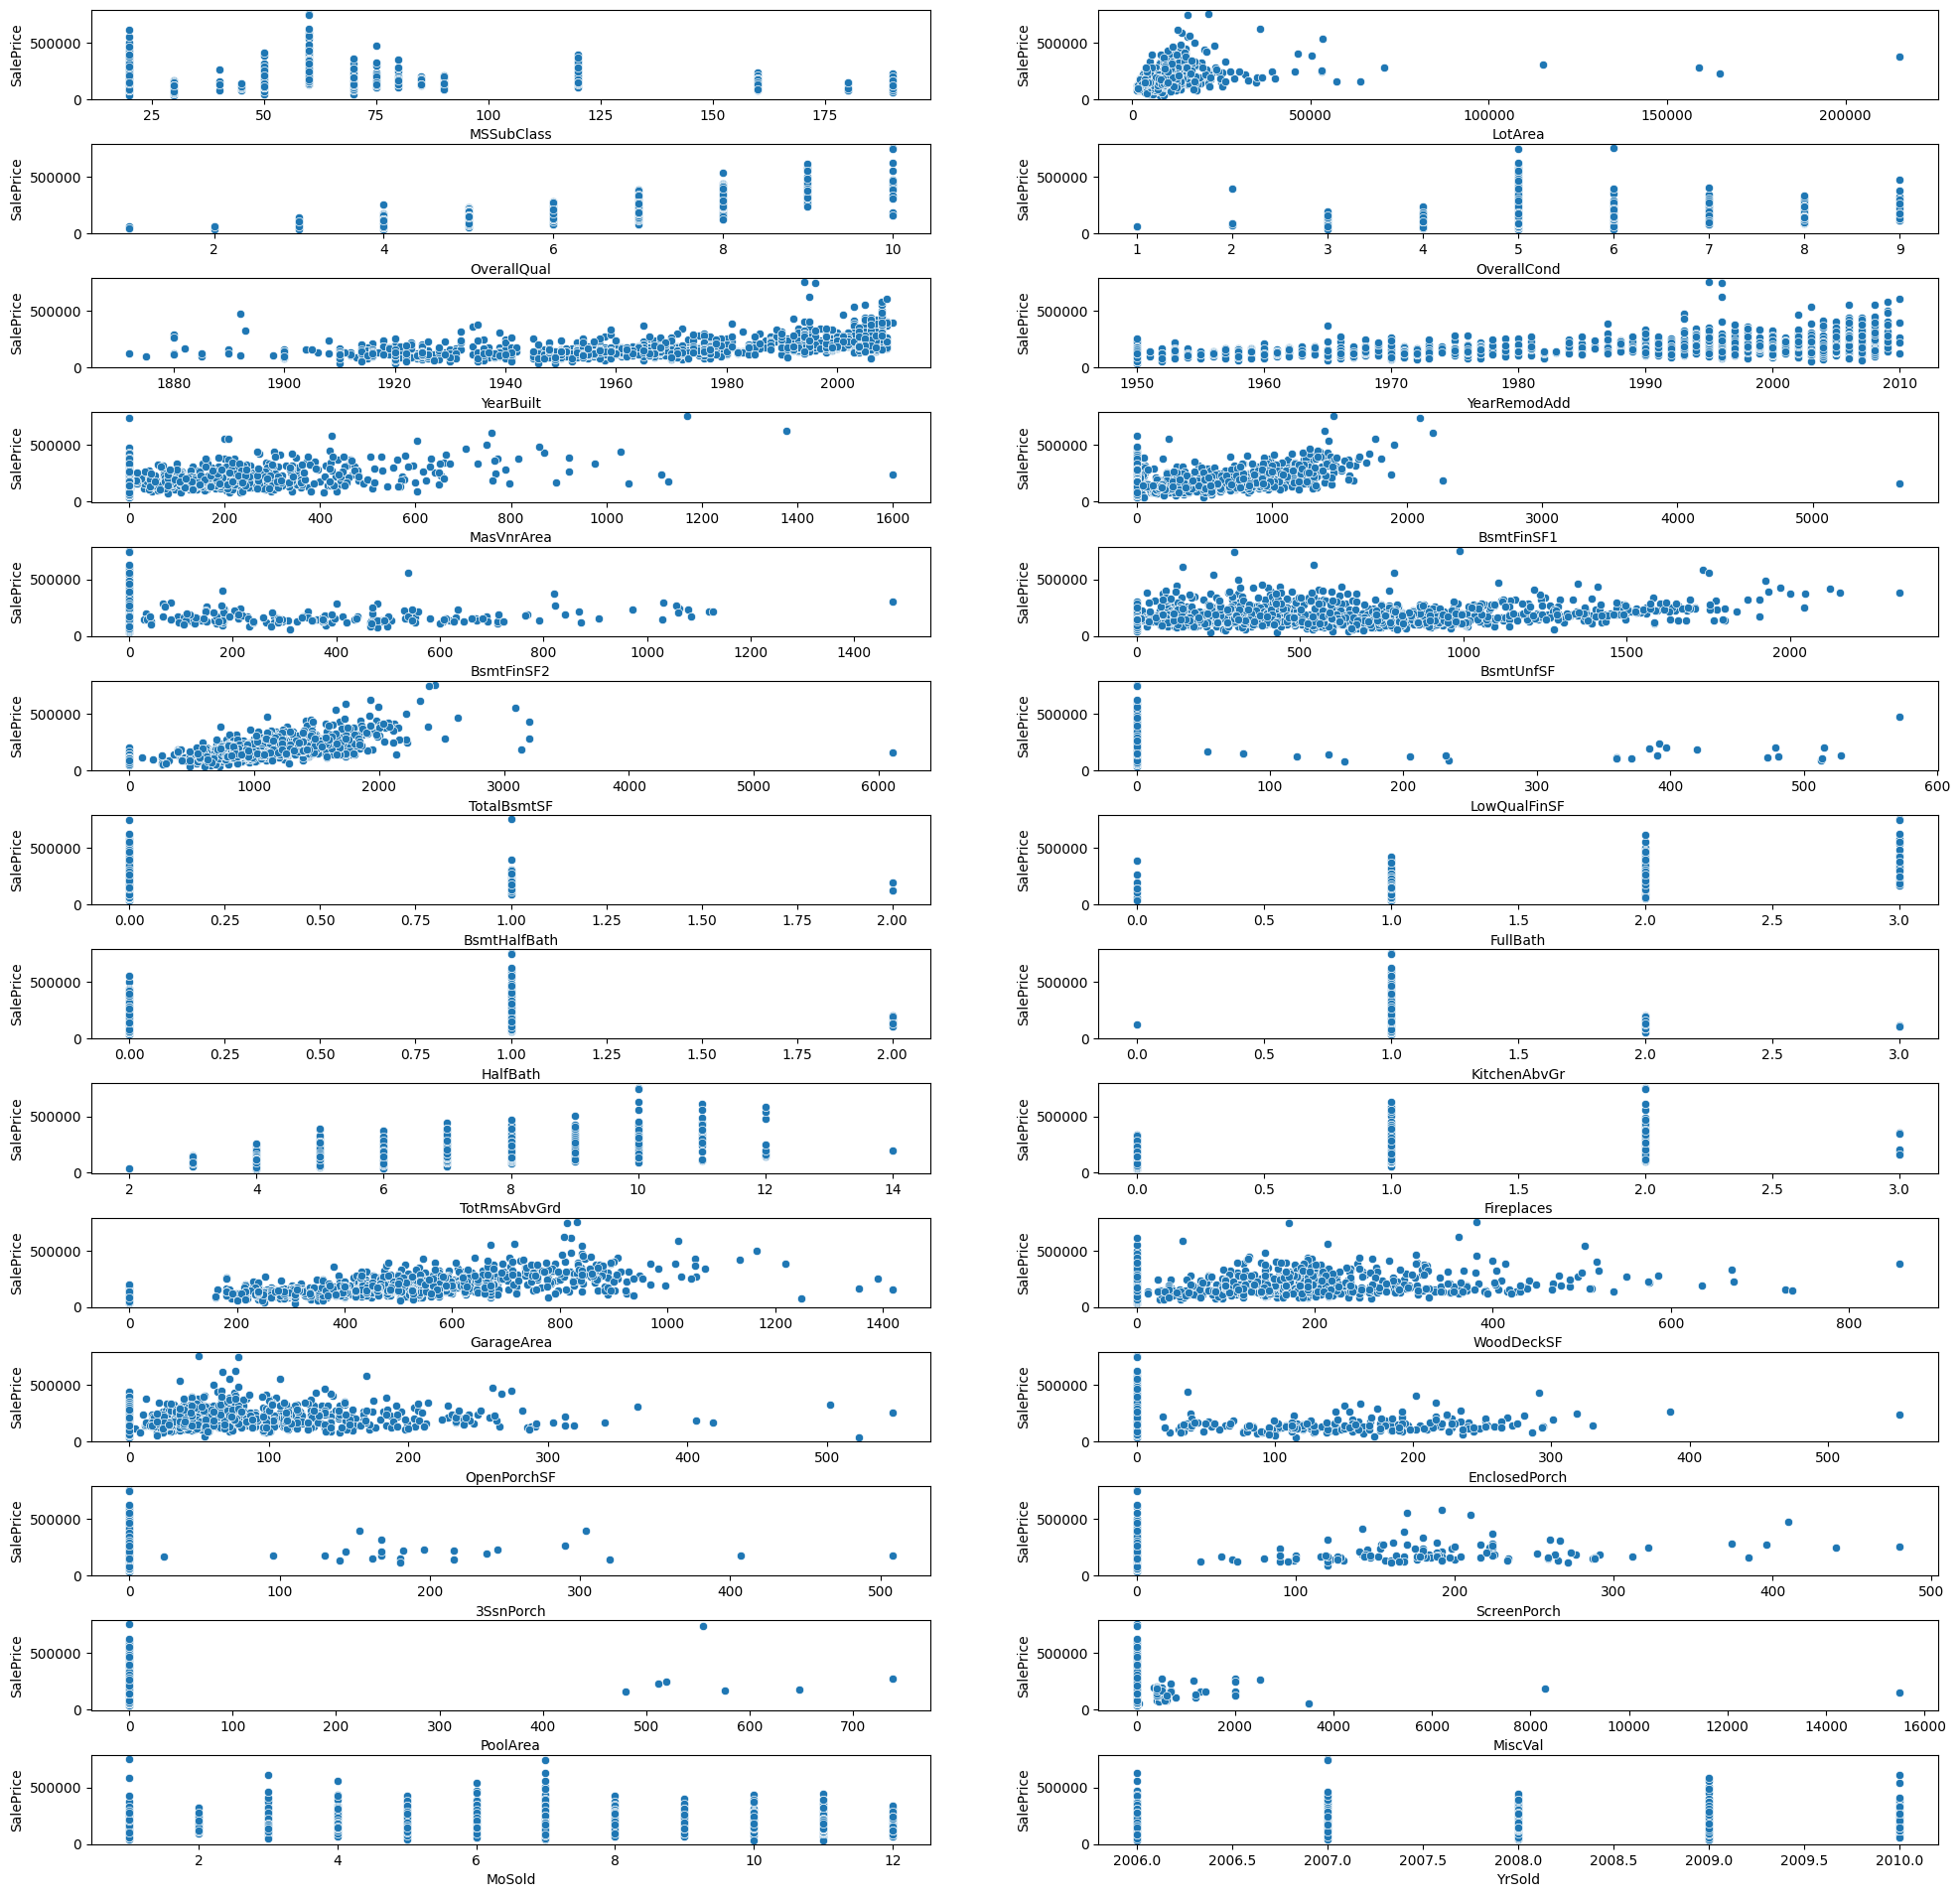

In [552]:
scatter_plot_all_numerics_grid(house.copy(), 'SalePrice', rows=14, cols=2, hspace=0.5)

Inferences:
Some of the feature variables against the SalePrice exhibit positive correlation and some of them negative correlation and some don't have no clear trend. So, those features that don't have a clear trend like scaterred points, might not have strong linear relationship wtih SalePrice. Ridge and Lasso might assign a coefficient close to zero to these features during regularization, effectively redicing its impact on the model.

#### Analyse Target Variable - SalePrice

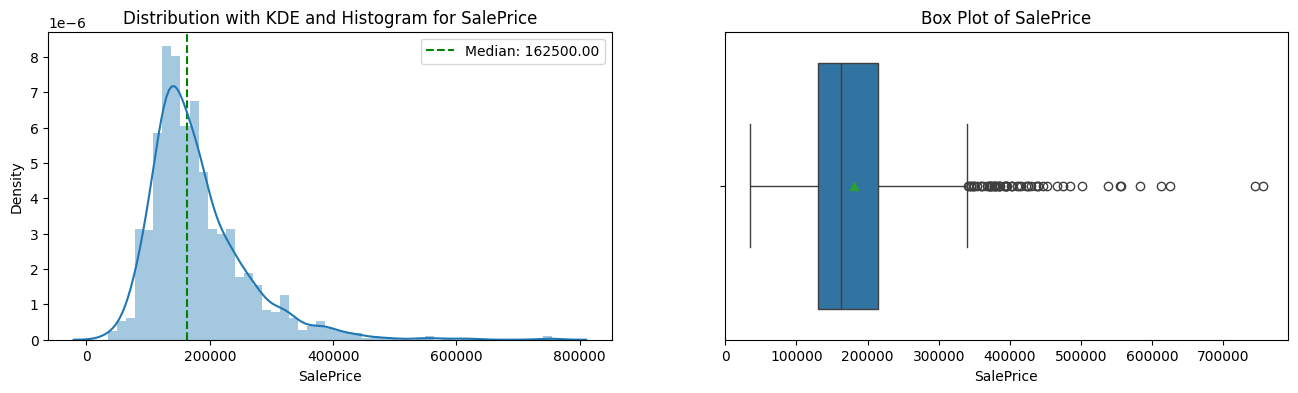

In [553]:
analyze_column_against_count(house.copy(), 'SalePrice')

The above plots clearly shows the SalePrice is highly right skewed, with a longer tail extending towards the higher Sale Price values. Since majority of them are buyers less than the median of low to middle level housing prices.

######Use Box-Cox Transformation

Using the Box-Cox transformation we can transform the target variable so that the data follows a normal distribution.Box-Cox transformation helps to improve the predictive power of the model because it cuts away white noise. It is worth to note the following points:
1. Box-Cox primarily addresses non-normality (data not following a normal distribution) in a target variable.
2. Box-Cox transforms the target variable to a more symmetrical and potentially closer-to-normal distribution.

Models that rely on normality assumptions (e.g., linear regression) might perform better with a transformed target variable that's closer to normal. This can lead to more reliable p-values and confidence intervals.


In [554]:
print(f"Skewness before Transformatin: {house['SalePrice'].skew()}")

Skewness before Transformatin: 1.8831110462405252


The value of 1.88 indicates positive skewness which means there are more high value data points on the right side of the mean. By transforming this variable we can improve the predictive power of the model.

In [555]:
house['transformed_price'], _ = stats.boxcox(house['SalePrice'])

Skewness after Transformation: -0.008645784715484406


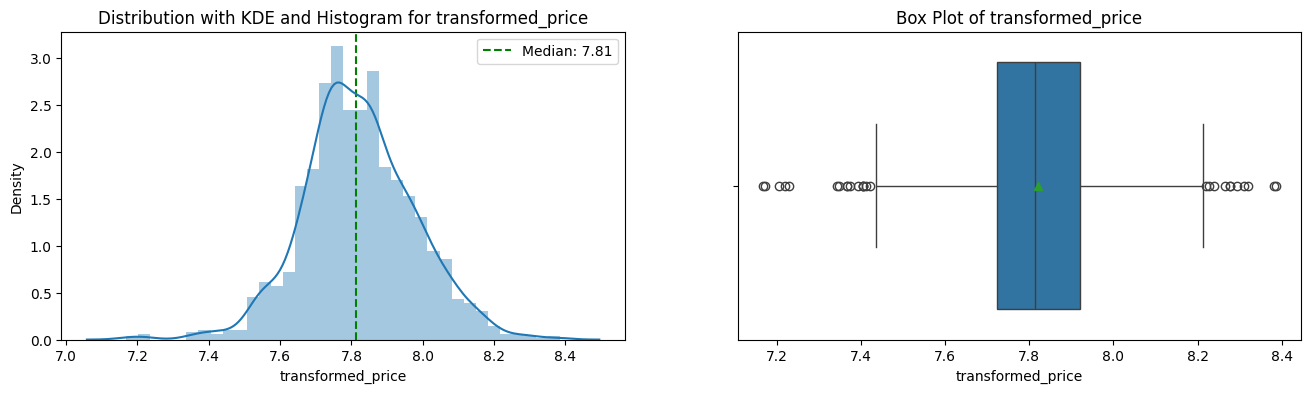

In [556]:
# Check if transformed_data is a Series
if isinstance(house['transformed_price'], pd.Series):
    print(f"Skewness after Transformation: {house['transformed_price'].skew()}")
else:
    print("Warning: Transformed data might be a single value. Skewness calculation skipped.")
analyze_column_against_count(house.copy(), 'transformed_price')

Looks like boxcalc transformation has done its magic and has made the sale price more normally distrubuted with equal distribution around the normal. The skewness value shown above also indicates the near normal distribution

In [557]:
house.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,...,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,transformed_price
0,1,60,RL,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,8,Typ,0,NA,Attchd,RFn,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,0,2,2008,WD,Normal,208500,7.910830
1,2,20,RL,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NA,...,6,Typ,1,TA,Attchd,RFn,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,0,5,2007,WD,Normal,181500,7.856833
2,3,60,RL,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,6,Typ,1,TA,Attchd,RFn,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,0,9,2008,WD,Normal,223500,7.937661
3,4,70,RL,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NA,...,7,Typ,1,Gd,Detchd,Unf,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,0,2,2006,WD,Abnorml,140000,7.754180
4,5,60,RL,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,9,Typ,1,TA,Attchd,RFn,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,0,12,2008,WD,Normal,250000,7.980634


### EDA on Categorical Variables

In [558]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1451 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 1451 non-null   int64  
 1   MSSubClass         1451 non-null   int64  
 2   MSZoning           1451 non-null   object 
 3   LotArea            1451 non-null   int64  
 4   Street             1451 non-null   object 
 5   Alley              1451 non-null   object 
 6   LotShape           1451 non-null   object 
 7   LandContour        1451 non-null   object 
 8   Utilities          1451 non-null   object 
 9   LotConfig          1451 non-null   object 
 10  LandSlope          1451 non-null   object 
 11  Neighborhood       1451 non-null   object 
 12  Condition1         1451 non-null   object 
 13  Condition2         1451 non-null   object 
 14  BldgType           1451 non-null   object 
 15  HouseStyle         1451 non-null   object 
 16  OverallQual        1451 non-n

In [559]:
categorical_cols = house.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)
print("Number of categorical features", len(categorical_cols))
print(f"Categorical features with null values: {[col for col in categorical_cols if house[col].isnull().any()]}")

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Number of categorical features 42
Categorical features with null values: []


It is clear that from the 42 features there are no variables that has any null values

In [560]:
house[categorical_cols].head(1)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NA,Attchd,RFn,TA,TA,Y,NA,NA,WD,Normal


In [561]:
house['CentralAir'].value_counts()

CentralAir
Y    1356
N      95
Name: count, dtype: int64

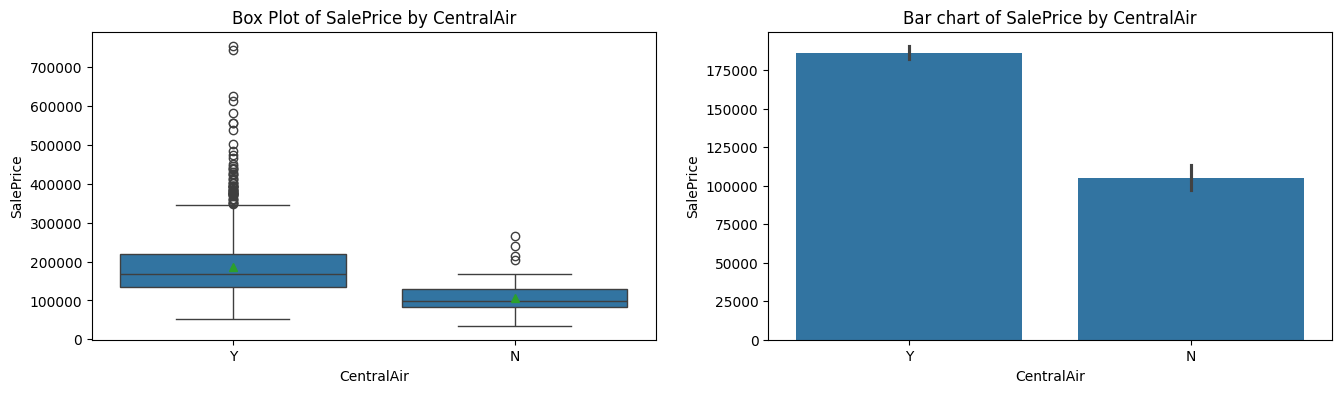

In [562]:
analyze_column_against_count(house, 'CentralAir')

For typically high priced properties have central air conditioning

##### Encode Categorical Varaibles

In [563]:
#feature_coded = pd.DataFrame()
for col in categorical_cols:
  feature = house[col].astype('category')
  house[col] = feature.cat.codes

house.head(5)

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,...,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,transformed_price
0,1,60,3,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,...,8,6,0,3,1,2,548,5,5,2,0,61,0,0,0,0,4,1,0,2,2008,8,4,208500,7.910830
1,2,20,3,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,...,6,6,1,5,1,2,460,5,5,2,298,0,0,0,0,0,4,1,0,5,2007,8,4,181500,7.856833
2,3,60,3,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,...,6,6,1,5,1,2,608,5,5,2,0,42,0,0,0,0,4,1,0,9,2008,8,4,223500,7.937661
3,4,70,3,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,...,7,6,1,2,5,3,642,5,5,2,0,35,272,0,0,0,4,1,0,2,2006,8,0,140000,7.754180
4,5,60,3,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,...,9,6,1,5,1,2,836,5,5,2,192,84,0,0,0,0,4,1,0,12,2008,8,4,250000,7.980634


In [564]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1451 entries, 0 to 1459
Data columns (total 73 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 1451 non-null   int64  
 1   MSSubClass         1451 non-null   int64  
 2   MSZoning           1451 non-null   int8   
 3   LotArea            1451 non-null   int64  
 4   Street             1451 non-null   int8   
 5   Alley              1451 non-null   int8   
 6   LotShape           1451 non-null   int8   
 7   LandContour        1451 non-null   int8   
 8   Utilities          1451 non-null   int8   
 9   LotConfig          1451 non-null   int8   
 10  LandSlope          1451 non-null   int8   
 11  Neighborhood       1451 non-null   int8   
 12  Condition1         1451 non-null   int8   
 13  Condition2         1451 non-null   int8   
 14  BldgType           1451 non-null   int8   
 15  HouseStyle         1451 non-null   int8   
 16  OverallQual        1451 non-n

In [565]:
columns = [col for col in house.columns if col not in ['Id', 'SalePrice', 'transformed_price']]
print(columns)

['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


We have now all the columns in number format and ready to prepare, build and test model

## Prepare Data for Modelling

#####Split into Train and Test Data

In [566]:
np.random.seed(0)
df_train, df_test = train_test_split(house, train_size=0.70, test_size=0.30, random_state=35)
df_train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,...,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,transformed_price
175,176,20,3,12615,1,1,3,3,0,0,0,7,2,2,0,2,6,7,1950,2001,1,1,14,15,2,...,7,6,1,2,1,3,576,5,5,2,0,29,39,0,0,0,2,1,0,6,2007,8,4,243000,7.969778
1335,1336,20,3,9650,1,1,3,3,0,4,0,14,2,2,0,2,6,5,1977,1977,1,1,9,10,1,...,6,6,1,5,1,2,630,5,5,2,0,16,0,0,0,0,4,1,0,4,2009,8,4,167900,7.826252
603,604,160,1,3182,1,2,3,3,0,4,0,21,2,2,4,5,7,5,2004,2005,1,1,8,8,2,...,4,6,0,3,5,2,480,5,5,2,0,172,0,0,0,0,4,1,0,6,2010,8,4,151000,7.784301
1423,1424,80,3,19690,1,1,0,3,0,1,0,7,2,2,0,7,6,7,1966,1966,0,5,9,10,2,...,8,6,1,2,1,3,432,2,2,2,586,236,0,0,0,738,0,1,0,8,2006,8,2,274970,8.016854
835,836,20,3,9600,1,1,3,3,0,4,0,19,2,2,0,2,4,7,1950,1995,1,1,12,6,2,...,4,3,0,3,1,3,436,5,5,2,290,0,0,0,0,0,4,1,0,2,2010,8,4,128000,7.718265


In [567]:
df_test.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,...,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,transformed_price
391,392,60,3,12209,1,1,0,3,0,1,0,11,2,2,0,5,6,5,2001,2002,1,1,12,13,2,...,7,6,1,5,3,0,560,5,5,2,125,192,0,0,0,0,4,1,0,6,2009,8,4,215000,7.922704
908,909,20,3,8885,1,1,0,2,0,4,1,11,2,2,0,2,5,5,1983,1983,1,1,6,6,2,...,5,6,0,3,1,3,484,5,5,2,164,0,0,0,0,0,2,1,0,6,2006,8,4,131000,7.727574
243,244,160,3,10762,1,1,3,3,0,0,0,20,2,2,4,5,6,6,1980,1980,1,1,9,10,2,...,6,6,1,5,1,2,288,5,5,2,0,28,0,0,0,0,4,1,0,4,2009,8,4,120000,7.692244
578,579,160,1,3604,1,2,3,3,0,0,0,21,2,2,4,5,7,5,2007,2007,1,1,12,13,2,...,5,6,0,3,5,3,540,5,5,2,0,102,0,0,0,0,4,1,0,2,2008,8,0,146000,7.770913
808,809,80,3,13400,1,1,3,3,0,4,0,12,2,2,0,7,5,5,1966,1966,1,1,12,13,1,...,6,6,1,2,1,2,484,5,5,2,0,0,0,0,0,0,1,1,0,6,2006,8,4,159950,7.807114


In [568]:
print(df_train.shape)
print(df_test.shape)

(1015, 73)
(436, 73)


In [569]:
# Create the X, y training and test data sets
y_train = df_train["transformed_price"]
X_train = df_train.drop(["Id", "SalePrice", "transformed_price"], axis=1)

y_test = df_test["transformed_price"]
X_test = df_test.drop(["Id", "SalePrice", "transformed_price"], axis=1)


In [570]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1015, 70)
(1015,)
(436, 70)
(436,)


##### Scaling the features

Since we have transformed the SalePrice to a normal distribution, Lets also scale the features to a standard normal distribution (mean 0, standard deviation 1). This is useful regression model since we assume a normal distribution for features.

In [571]:
#scaler = MinMaxScaler()
scaler = StandardScaler()


In [572]:
X_train_scaled = scaler.fit_transform(X_train[columns])
X_test_scaled = scaler.transform(X_test[columns])

In [573]:
X_train[columns] = X_train_scaled
X_test[columns] = X_test_scaled

In [574]:
X_train.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
175,-0.878070,-0.074470,0.206739,0.054447,0.023548,0.729314,0.317305,0.0,-1.857520,-0.208737,-0.870684,-0.026675,-0.019177,-0.411216,-0.526070,-0.060732,1.291926,-0.674016,0.792023,-0.493717,-0.118808,1.371076,1.314103,0.417557,-0.576888,...,-0.223491,-0.417936,0.284949,0.260366,0.606677,-0.925682,-0.781445,0.931531,0.476469,0.329559,0.303066,0.290416,-0.746999,-0.246305,0.266842,-0.126268,-0.259476,-0.076205,-1.425831,-0.19403,-0.090985,-0.113007,-0.607074,0.314293,0.213636
1335,-0.878070,-0.074470,-0.086055,0.054447,0.023548,0.729314,0.317305,0.0,0.599805,-0.208737,0.309890,-0.026675,-0.019177,-0.411216,-0.526070,-0.060732,-0.497030,0.213776,-0.365158,-0.493717,-0.118808,-0.206034,-0.115801,-1.193928,1.363704,...,-0.223491,0.777008,-0.343797,0.260366,0.606677,1.669807,-0.781445,0.094061,0.723795,0.329559,0.303066,0.290416,-0.746999,-0.443849,-0.359406,-0.126268,-0.259476,-0.076205,0.448804,-0.19403,-0.090985,-0.872626,0.895805,0.314293,0.213636
603,2.447899,-3.360852,-0.724772,0.054447,4.007035,0.729314,0.317305,0.0,0.599805,-0.208737,1.490464,-0.026675,-0.019177,2.961583,1.029156,0.664484,-0.497030,1.101568,0.984886,-0.493717,-0.118808,-0.521456,-0.687763,0.417557,-0.576888,...,-0.223491,-0.417936,-1.601290,0.260366,-0.936625,-0.060519,1.269406,0.094061,0.036776,0.329559,0.303066,0.290416,-0.746999,1.926677,-0.359406,-0.126268,-0.259476,-0.076205,0.448804,-0.19403,-0.090985,-0.113007,1.647245,0.314293,0.213636
1423,0.547345,-0.074470,0.905397,0.054447,0.023548,-1.422586,0.317305,0.0,-1.243189,-0.208737,-0.870684,-0.026675,-0.019177,-0.411216,2.065974,-0.060732,1.291926,-0.147917,-0.895533,-1.684031,6.871909,-0.206034,-0.115801,0.417557,-0.576888,...,-0.223491,-0.417936,0.913695,0.260366,0.606677,-0.925682,-0.781445,0.931531,-0.183070,-2.928578,-3.463607,0.290416,4.010604,2.899201,-0.359406,-0.126268,-0.259476,16.359938,-3.300465,-0.19403,-0.090985,0.646611,-1.358514,0.314293,-1.585868
835,-0.878070,-0.074470,-0.090993,0.054447,0.023548,0.729314,0.317305,0.0,0.599805,-0.208737,1.153157,-0.026675,-0.019177,-0.411216,-0.526070,-1.511165,1.291926,-0.674016,0.502728,-0.493717,-0.118808,0.740232,-1.259725,0.417557,-0.576888,...,-0.223491,-0.417936,-1.601290,-2.800695,-0.936625,-0.060519,-0.781445,0.931531,-0.164749,0.329559,0.303066,0.290416,1.607446,-0.686979,-0.359406,-0.126268,-0.259476,-0.076205,0.448804,-0.19403,-0.090985,-1.632245,1.647245,0.314293,0.213636


In [575]:
X_test.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,...,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
391,0.072207,-0.074470,0.166647,0.054447,0.023548,-1.422586,0.317305,0.0,-1.243189,-0.208737,-0.196070,-0.026675,-0.019177,-0.411216,1.029156,-0.060732,-0.497030,1.002925,0.840239,-0.493717,-0.118808,0.740232,0.742142,0.417557,-0.576888,...,-0.223491,-0.417936,0.284949,0.260366,0.606677,1.669807,0.243981,-1.580880,0.403187,0.329559,0.303066,0.290416,0.267848,2.230591,-0.359406,-0.126268,-0.259476,-0.076205,0.448804,-0.19403,-0.090985,-0.113007,0.895805,0.314293,0.213636
908,-0.878070,-0.074470,-0.161599,0.054447,0.023548,-1.422586,-1.101483,0.0,0.599805,3.574627,-0.196070,-0.026675,-0.019177,-0.411216,-0.526070,-0.785949,-0.497030,0.411063,-0.075863,-0.493717,-0.118808,-1.152300,-1.259725,0.417557,-0.576888,...,-0.223491,0.777008,-0.972544,0.260366,-0.936625,-0.060519,-0.781445,0.931531,0.055097,0.329559,0.303066,0.290416,0.584480,-0.686979,-0.359406,-0.126268,-0.259476,-0.076205,-1.425831,-0.19403,-0.090985,-0.113007,-1.358514,0.314293,0.213636
243,2.447899,-0.074470,0.023755,0.054447,0.023548,0.729314,0.317305,0.0,-1.857520,-0.208737,1.321811,-0.026675,-0.019177,2.961583,1.029156,-0.060732,0.397448,0.312420,-0.220510,-0.493717,-0.118808,-0.206034,-0.115801,0.417557,-0.576888,...,-0.223491,0.777008,-0.343797,0.260366,0.606677,1.669807,-0.781445,0.094061,-0.842608,0.329559,0.303066,0.290416,-0.746999,-0.261500,-0.359406,-0.126268,-0.259476,-0.076205,0.448804,-0.19403,-0.090985,-0.872626,0.895805,0.314293,0.213636
578,2.447899,-3.360852,-0.683099,0.054447,4.007035,0.729314,0.317305,0.0,-1.857520,-0.208737,1.490464,-0.026675,-0.019177,2.961583,1.029156,0.664484,-0.497030,1.200212,1.081318,-0.493717,-0.118808,0.740232,0.742142,0.417557,-0.576888,...,-0.223491,-0.417936,-0.972544,0.260366,-0.936625,-0.060519,1.269406,0.931531,0.311584,0.329559,0.303066,0.290416,-0.746999,0.862980,-0.359406,-0.126268,-0.259476,-0.076205,0.448804,-0.19403,-0.090985,-1.632245,0.144365,0.314293,-3.385372
808,0.547345,-0.074470,0.284258,0.054447,0.023548,0.729314,0.317305,0.0,0.599805,-0.208737,-0.027417,-0.026675,-0.019177,-0.411216,2.065974,-0.785949,-0.497030,-0.147917,-0.895533,-0.493717,-0.118808,0.740232,0.742142,-1.193928,5.066999,...,-0.223491,0.777008,-0.343797,0.260366,0.606677,-0.925682,-0.781445,0.094061,0.055097,0.329559,0.303066,0.290416,-0.746999,-0.686979,-0.359406,-0.126268,-0.259476,-0.076205,-2.363148,-0.19403,-0.090985,-0.113007,-1.358514,0.314293,0.213636


## Model Building Using RFECV

In [576]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Create RFECV object with linear regression estimator, step size of 1, and 5-fold cross-validation
rfecv = RFECV(lr, step=1, cv=5)
rfecv.fit(X_train, y_train)

RFECV(cv=5, estimator=LinearRegression())

In [577]:
# Get the number of features selected by RFECV based on best cross-validated performance
optimal_features_rfecv = rfecv.n_features_

# Get the indices of the selected features
rfecv_support = rfecv.support_

# Get the names of the selected features (assuming you have feature names)
selected_features_rfecv = X_train.columns[rfecv_support]

print(f"RFECV Selected Features ({optimal_features_rfecv} features): {selected_features_rfecv}")


RFECV Selected Features (27 features): Index(['LotArea', 'Utilities', 'BldgType', 'OverallQual', 'OverallCond',
       'YearBuilt', 'Exterior1st', 'Exterior2nd', 'Foundation', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       'FullBath', 'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageArea', 'PavedDrive', 'WoodDeckSF', 'EnclosedPorch',
       'ScreenPorch', 'PoolArea', 'SaleCondition'],
      dtype='object')


##### Analysis on RFECV results

In [578]:
X_train_ols = sm.add_constant(X_train[selected_features_rfecv])
sm_ols = sm.OLS(y_train.values.reshape(-1,1), X_train_ols).fit()
print(sm_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     233.5
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:02:24   Log-Likelihood:                 1416.7
No. Observations:                1015   AIC:                            -2781.
Df Residuals:                     989   BIC:                            -2653.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.8188      0.002   4103.556

The output of sm_ols.summary() contains various statistics about the fitted linear regression model. Here are some key points:

* **P-values**: Looking for features with high p-values (typically greater than 0.05). Since, a high p-value indicates that the coefficient (the effect of the feature on the target variable) might not be statistically significant. These features might be candidates for elimination.The only Feature that we could notice here is **BsmtUnfSF** that has p-value of 0.955

* **Coefficients**: While p-values are important, also considering the coefficient values themselves. Even if a feature has a low p-value (statistically significant), its coefficient might be very small in magnitude. Following are the only 2 features that have very less coefficients:

  * BsmtUnfSF      
  * Utilities      

 This suggests a weak influence on the target variable. Therefore, Such features could be considered for removal if eliminating them doesn't significantly impact the model's performance.

* **R-squared and Adjusted R-squared**: Both are at 85%, which is very good. These statistics represent the proportion of variance in the target variable explained by the model. If removing a feature leads to a significant drop in R-squared or adjusted R-squared, it might be important to keep it.

###### VIF Analysis

In [579]:
X_train_rfe = X_train[selected_features_rfecv]
#check VIF of RFE Model
print_vif_data(X_train_rfe)

         Features   VIF
11      BsmtUnfSF   inf
10     BsmtFinSF2   inf
12    TotalBsmtSF   inf
9      BsmtFinSF1   inf
5       YearBuilt  4.62
7     Exterior2nd  3.55
6     Exterior1st  3.52
3     OverallQual  3.05
15       FullBath  2.29
18   TotRmsAbvGrd  2.19
8      Foundation  1.92
20     GarageArea  1.82
17    KitchenQual  1.67
4     OverallCond  1.48
13      HeatingQC  1.46
16       HalfBath  1.46
19     Fireplaces  1.45
14     CentralAir  1.43
21     PavedDrive  1.35
23  EnclosedPorch  1.28
2        BldgType  1.23
0         LotArea  1.22
22     WoodDeckSF  1.18
24    ScreenPorch  1.12
26  SaleCondition  1.12
25       PoolArea  1.05
1       Utilities   NaN


VIF Interpretation: There's no single threshold for a "high" VIF. But, inthe industry, following are observed as a general guideline:
* **VIF < 5**: Likely not a major concern for multicollinearity.
* **5 <= VIF < 10**: Might indicate some multicollinearity, but further investigation is needed.
* **VIF >= 10**: Suggests strong multicollinearity, and these features are likely candidates for elimination.

From the SM stats summary and VIF interpretations, its absolutely clear the feature **BsmtUnfSF** might be the first candidate to target.
BsmtUnfSF: Unfinished square feet of basement area

#### Model 2

In [580]:
# Lets drop Utilities and BsmtUnfSF which is Unfinished square feet of basement area from the model and analyse the results:
X_train_rfe_new = X_train_rfe.drop(['BsmtUnfSF','Utilities'], axis=1)
X_train_ols = sm.add_constant(X_train_rfe_new)
sm_ols = sm.OLS(y_train.values.reshape(-1,1), X_train_ols).fit()
print(sm_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     233.5
Date:                Tue, 30 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:02:24   Log-Likelihood:                 1416.7
No. Observations:                1015   AIC:                            -2781.
Df Residuals:                     989   BIC:                            -2653.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.8188      0.002   4103.556

#####Summary
We were able to retain R-Square and Adj. R-Squared at 85% and also the p-values of all feature variables at less than 0.05. Lets look at the VIF data and analyse its results.

##### VIF Analysis

In [581]:
print_vif_data(X_train_rfe_new)

         Features   VIF
4       YearBuilt  4.62
6     Exterior2nd  3.55
5     Exterior1st  3.52
2     OverallQual  3.05
10    TotalBsmtSF  2.42
13       FullBath  2.29
16   TotRmsAbvGrd  2.19
7      Foundation  1.92
18     GarageArea  1.82
15    KitchenQual  1.67
8      BsmtFinSF1  1.61
3     OverallCond  1.48
11      HeatingQC  1.46
14       HalfBath  1.46
17     Fireplaces  1.45
12     CentralAir  1.43
19     PavedDrive  1.35
21  EnclosedPorch  1.28
1        BldgType  1.23
0         LotArea  1.22
20     WoodDeckSF  1.18
9      BsmtFinSF2  1.12
22    ScreenPorch  1.12
24  SaleCondition  1.12
23       PoolArea  1.05




---


We can observe that all the features are **less than 5** indicating the features are not a major concern for multicollinearity


---



## Residual Analysis on Training Data

In [582]:
y_train_pred = sm_ols.predict(X_train_ols)
residuals = (y_train-y_train_pred)

Text(0.5, 0, 'Errors')

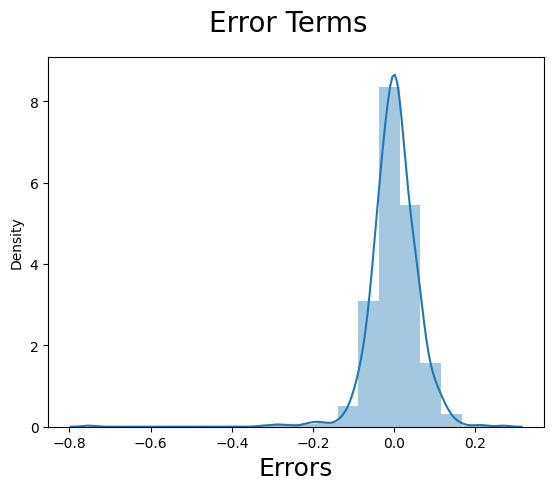

In [583]:
# Let us plot the histogram of the error terms
fig = plt.figure()
sns.distplot(residuals, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 18)



---
The error terms are very nicely normally distributed with mean 0.


---





In [584]:
X_test_rfe_new = X_test[X_train_rfe_new.columns]
lr = LinearRegression()
lr.fit(X_train_rfe_new, y_train)


y_pred_train = lr.predict(X_train_rfe_new)
y_pred_test = lr.predict(X_test_rfe_new)

#### Prepare Linear Regression Metric model for later analysis with Regularization Metrics

In [585]:
linear_model = {}
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
linear_model['r2_train'] = r2_train_lr

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
linear_model['r2_test'] = r2_test_lr

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
linear_model['rss_train'] = rss1_lr

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
linear_model['rss_test']= rss2_lr

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
linear_model['mse_train'] = mse_train_lr

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
linear_model['mse_test'] = mse_test_lr

print(linear_model)


0.8551171437050185
0.8656983954924873
3.6443808907635034
1.4383402952060593
0.0035905230450871952
0.003298945631206558
{'r2_train': 0.8551171437050185, 'r2_test': 0.8656983954924873, 'rss_train': 3.6443808907635034, 'rss_test': 1.4383402952060593, 'mse_train': 0.0035905230450871952, 'mse_test': 0.003298945631206558}


In [586]:
Lr_model = collections.namedtuple("Lr_model", linear_model.keys())
lr_model = Lr_model(**linear_model)
print(lr_model)

Lr_model(r2_train=0.8551171437050185, r2_test=0.8656983954924873, rss_train=3.6443808907635034, rss_test=1.4383402952060593, mse_train=0.0035905230450871952, mse_test=0.003298945631206558)


## Ridge Regression

In [587]:
print(X_train_rfe_new.columns)
print(len(X_train_rfe_new.columns))

Index(['LotArea', 'BldgType', 'OverallQual', 'OverallCond', 'YearBuilt',
       'Exterior1st', 'Exterior2nd', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2',
       'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'FullBath', 'HalfBath',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'PavedDrive',
       'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch', 'PoolArea',
       'SaleCondition'],
      dtype='object')
25


In [588]:
# Create a RegularizedLinearRegression object for ridge regression
ridge_model = RegularizedLinearRegression(X_train_rfe_new, y_train, X_test_rfe_new, y_test, model_name="ridge")

# Print the results
ridge_model.PrintRegressionResults()

Fitting 5 folds for each of 32 candidates, totalling 160 fits
** ridge Regression Results **
Best Alpha: 100.0000
Training R-squared: 0.8538
Testing R-squared: 0.8659
Training Residual Sum of Squares (RSS): 3.6781
Testing Residual Sum of Squares (RSS): 1.4366
Training Mean Squared Error: 0.0036
Testing Mean Squared Error: 0.0033
Coefficients:
[ 0.00990549 -0.00687335  0.0424386   0.01745785  0.0174795  -0.00499928
  0.00508773  0.00955555  0.0116606   0.00462504  0.01553176 -0.00860171
  0.00936029  0.01693523  0.01180516 -0.0114278   0.01977446  0.01506986
  0.0201036   0.00801874  0.00981114  0.00638428  0.00808187 -0.00613095
  0.01087571]


Comment:
We can observe that the R-Squared for Test is better than the Training dataset.

Let us look at how the alpha value progress against mean squared error for alpha = 100

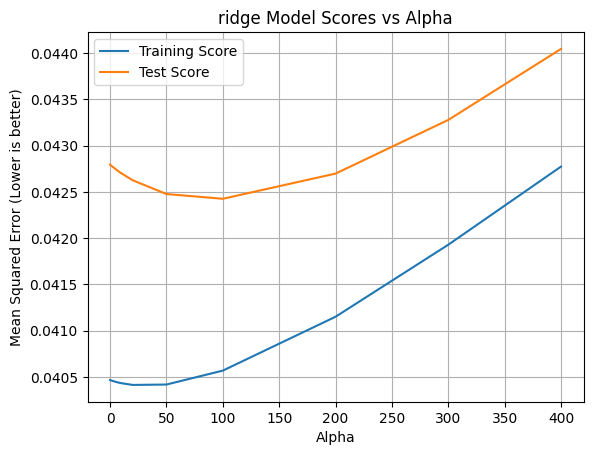

In [589]:
ridge_model.Plot_alpha_vs_mean_scores()

## Lasso Regression

In [590]:
lasso_model = RegularizedLinearRegression(X_train_rfe_new, y_train, X_test_rfe_new, y_test, model_name="lasso")
lasso_model.PrintRegressionResults()

Fitting 5 folds for each of 32 candidates, totalling 160 fits
** lasso Regression Results **
Best Alpha: 0.0001
Training R-squared: 0.8551
Testing R-squared: 0.8661
Training Residual Sum of Squares (RSS): 3.6446
Testing Residual Sum of Squares (RSS): 1.4338
Training Mean Squared Error: 0.0036
Testing Mean Squared Error: 0.0033
Coefficients:
[ 0.01042499 -0.00718541  0.04835386  0.01981295  0.02004709 -0.00772684
  0.00725813  0.0091977   0.01226225  0.00523188  0.0143722  -0.00788502
  0.00828002  0.01592967  0.01136502 -0.00959783  0.02065065  0.01451358
  0.01995428  0.00762422  0.00990317  0.00774774  0.00844785 -0.00701006
  0.0110235 ]


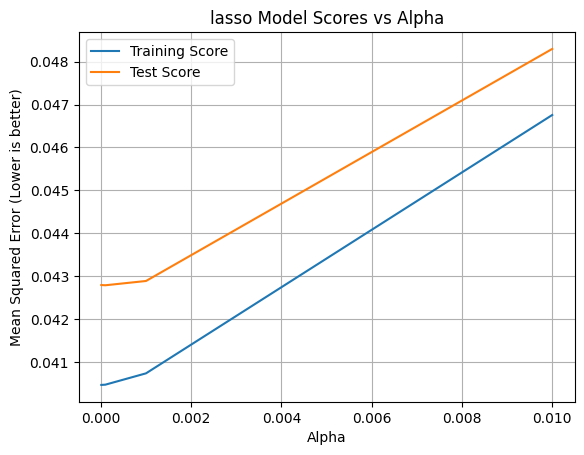

In [591]:
lasso_model.Plot_alpha_vs_mean_scores(skip = -28)

## Model Analysis

Here we compare the models created using Linear, Ridge and Lasso Regression models and analyse and evaluate the best

In [592]:
RegressionMetricsPrinter(linear_model=lr_model, ridge_model=ridge_model, lasso_model=lasso_model)

             Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)           0.855117          0.853777          0.855106
1   R2 Score (Test)           0.865698          0.865862          0.866119
2       RSS (Train)           3.644381          3.678083          3.644650
3        RSS (Test)           1.438340          1.436583          1.433840
4       MSE (Train)           0.003591          0.003624          0.003591
5        MSE (Test)           0.003299          0.003295          0.003289




---

**Lasso Regression produces slightly better model with its performance slightly better than others in Testing (unseen) data, so we can consider the lasso model as the final model**


---



In [593]:
beta_coefficients = pd.DataFrame(index=X_train_rfe_new.columns)
beta_coefficients.rows = X_train_rfe_new.columns

beta_coefficients['Linear Regression'] = lr.coef_
beta_coefficients['Ridge (alpha=100)'] = ridge_model.coef_
beta_coefficients['Lasso (alpha=0.0001)'] = lasso_model.coef_
pd.set_option('display.max_rows', None)
center_aligned_df = beta_coefficients.style.set_properties(**{'text-align': 'center'})
display(center_aligned_df)

,Linear Regression,Ridge (alpha=100),Lasso (alpha=0.0001)
LotArea,0.010501,0.009905,0.010425
BldgType,-0.007247,-0.006873,-0.007185
OverallQual,0.048210,0.042439,0.048354
OverallCond,0.019965,0.017458,0.019813
YearBuilt,0.020257,0.017480,0.020047
Exterior1st,-0.008362,-0.004999,-0.007727
Exterior2nd,0.007874,0.005088,0.007258
Foundation,0.009256,0.009556,0.009198
BsmtFinSF1,0.012341,0.011661,0.012262
BsmtFinSF2,0.005311,0.004625,0.005232


## Final Model

As already mentioned, we saw that lasso produces slightly better model with better R2 Score on test data. The Residual sum of squares (Squared sum of error terms) and mean square error was also better than ridge models.

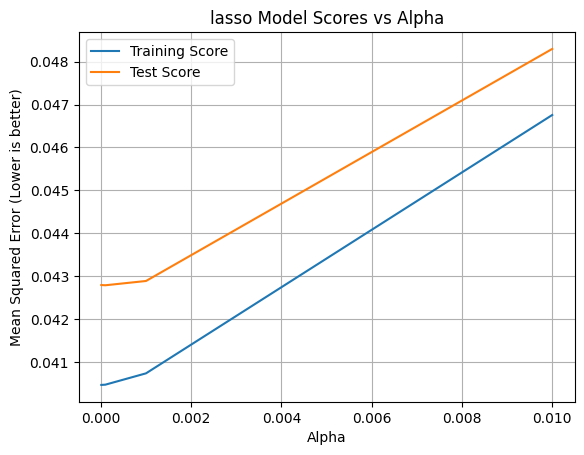

In [594]:
lasso_model.Plot_alpha_vs_mean_scores(skip=-28)

In [595]:
# Top 25 features ordered by feature importance in Lasso Regression
beta_coefficients[['Lasso (alpha=0.0001)']].sort_values(by='Lasso (alpha=0.0001)', ascending=False)

,Lasso (alpha=0.0001)
OverallQual,0.048354
TotRmsAbvGrd,0.020651
YearBuilt,0.020047
GarageArea,0.019954
OverallCond,0.019813
FullBath,0.015930
Fireplaces,0.014514
TotalBsmtSF,0.014372
BsmtFinSF1,0.012262
HalfBath,0.011365


## Summary



---
The top 25 features selected using lasso model is shown above for alpha (penalty) of 0.0001


# Subjective Questions


##Q1. What will be the changes in the model if you choose to double the value of alpha for both ridge and lasso?



In [596]:
best_ridge_alpha = 100
# Create a RegularizedLinearRegression object for ridge regression
ridge_model_with_alpha_doubled = RegularizedLinearRegression(X_train_rfe_new, y_train, X_test_rfe_new, y_test, model_name="ridge", alpha=best_ridge_alpha*2)

# Print the results
ridge_model_with_alpha_doubled.PrintRegressionResults()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
** ridge Regression Results **
Best Alpha: 200.0000
Training R-squared: 0.8511
Testing R-squared: 0.8640
Training Residual Sum of Squares (RSS): 3.7461
Testing Residual Sum of Squares (RSS): 1.4565
Training Mean Squared Error: 0.0037
Testing Mean Squared Error: 0.0033
Coefficients:
[ 0.0095288  -0.00653006  0.03868915  0.01553687  0.01617896 -0.00344332
  0.00397812  0.00949303  0.01122678  0.00412009  0.01590177 -0.0090177
  0.00985101  0.01707724  0.01173477 -0.0123786   0.019239    0.01527162
  0.01998129  0.00809859  0.00969502  0.00525187  0.00771258 -0.00529618
  0.01061741]


In [597]:
best_lasso_alpha = 0.0001
lasso_model_with_alpha_doubled = RegularizedLinearRegression(X_train_rfe_new, y_train, X_test_rfe_new, y_test, model_name="lasso", alpha=best_lasso_alpha*2)

# Print the results
lasso_model_with_alpha_doubled.PrintRegressionResults()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
** lasso Regression Results **
Best Alpha: 0.0002
Training R-squared: 0.8551
Testing R-squared: 0.8665
Training Residual Sum of Squares (RSS): 3.6455
Testing Residual Sum of Squares (RSS): 1.4296
Training Mean Squared Error: 0.0036
Testing Mean Squared Error: 0.0033
Coefficients:
[ 0.01035081 -0.007123    0.04850435  0.01965748  0.0198318  -0.007093
  0.00664217  0.00913848  0.01218273  0.00515333  0.01436014 -0.00785675
  0.00827257  0.01587945  0.01129124 -0.00954399  0.0206127   0.01452395
  0.01999918  0.00758773  0.0098308   0.00752029  0.0083497  -0.0068587
  0.01096823]


In [598]:
RegressionMetricsPrinter(linear_model=lr_model, ridge_model=ridge_model_with_alpha_doubled, lasso_model=lasso_model_with_alpha_doubled)

             Metric  Linear Regression  Ridge Regression  Lasso Regression
0  R2 Score (Train)           0.855117          0.851074          0.855074
1   R2 Score (Test)           0.865698          0.864005          0.866514
2       RSS (Train)           3.644381          3.746074          3.645461
3        RSS (Test)           1.438340          1.456478          1.429606
4       MSE (Train)           0.003591          0.003691          0.003592
5        MSE (Test)           0.003299          0.003341          0.003279


In [599]:
beta_coefficients = pd.DataFrame(index=X_train_rfe_new.columns)
beta_coefficients.rows = X_train_rfe_new.columns
beta_coefficients['Ridge (alpha=100)'] = ridge_model.coef_
beta_coefficients['Ridge (alpha=200)'] = ridge_model_with_alpha_doubled.coef_
beta_coefficients['Lasso (alpha=0.0001)'] = lasso_model.coef_
beta_coefficients['Lasso (alpha=0.0002)'] = lasso_model_with_alpha_doubled.coef_
pd.set_option('display.max_rows', None)
center_aligned_df = beta_coefficients.style.set_properties(**{'text-align': 'center'})
display(center_aligned_df)

,Ridge (alpha=100),Ridge (alpha=200),Lasso (alpha=0.0001),Lasso (alpha=0.0002)
LotArea,0.009905,0.009529,0.010425,0.010351
BldgType,-0.006873,-0.006530,-0.007185,-0.007123
OverallQual,0.042439,0.038689,0.048354,0.048504
OverallCond,0.017458,0.015537,0.019813,0.019657
YearBuilt,0.017480,0.016179,0.020047,0.019832
Exterior1st,-0.004999,-0.003443,-0.007727,-0.007093
Exterior2nd,0.005088,0.003978,0.007258,0.006642
Foundation,0.009556,0.009493,0.009198,0.009138
BsmtFinSF1,0.011661,0.011227,0.012262,0.012183
BsmtFinSF2,0.004625,0.004120,0.005232,0.005153



---
**We still pick lasso model, as it provides slighlty better performance metrics**


---




In [600]:
# Top 5 features ordered by feature importance in Lasso Regression
beta_coefficients[['Lasso (alpha=0.0001)','Lasso (alpha=0.0002)']].sort_values(by='Lasso (alpha=0.0002)', ascending=False).head(5)

,Lasso (alpha=0.0001),Lasso (alpha=0.0002)
OverallQual,0.048354,0.048504
TotRmsAbvGrd,0.020651,0.020613
GarageArea,0.019954,0.019999
YearBuilt,0.020047,0.019832
OverallCond,0.019813,0.019657




---
Note that with the previous best alpha model of 0.0001, YearBuilt was at 3rd and GarageArea was 4th, but YearBuilt dropped to 4th when alpha is doubled.


---




##Q3. After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

In [601]:
drop_columns = beta_coefficients[['Lasso (alpha=0.0001)','Lasso (alpha=0.0002)']].sort_values(by='Lasso (alpha=0.0002)', ascending=False).head(5).index

print(drop_columns)

Index(['OverallQual', 'TotRmsAbvGrd', 'GarageArea', 'YearBuilt',
       'OverallCond'],
      dtype='object')


In [602]:
X_train_rfe_new.drop(columns=drop_columns, axis=1, inplace=True)
X_test_rfe_new.drop(columns=drop_columns, axis=1, inplace=True)
X_train_rfe_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1015 entries, 175 to 1303
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1015 non-null   float64
 1   BldgType       1015 non-null   float64
 2   Exterior1st    1015 non-null   float64
 3   Exterior2nd    1015 non-null   float64
 4   Foundation     1015 non-null   float64
 5   BsmtFinSF1     1015 non-null   float64
 6   BsmtFinSF2     1015 non-null   float64
 7   TotalBsmtSF    1015 non-null   float64
 8   HeatingQC      1015 non-null   float64
 9   CentralAir     1015 non-null   float64
 10  FullBath       1015 non-null   float64
 11  HalfBath       1015 non-null   float64
 12  KitchenQual    1015 non-null   float64
 13  Fireplaces     1015 non-null   float64
 14  PavedDrive     1015 non-null   float64
 15  WoodDeckSF     1015 non-null   float64
 16  EnclosedPorch  1015 non-null   float64
 17  ScreenPorch    1015 non-null   float64
 18  PoolArea   

In [603]:
lasso_model = RegularizedLinearRegression(X_train_rfe_new, y_train, X_test_rfe_new, y_test, model_name="lasso")
lasso_model.PrintRegressionResults()

Fitting 5 folds for each of 32 candidates, totalling 160 fits
** lasso Regression Results **
Best Alpha: 0.0010
Training R-squared: 0.7727
Testing R-squared: 0.7748
Training Residual Sum of Squares (RSS): 5.7173
Testing Residual Sum of Squares (RSS): 2.4114
Training Mean Squared Error: 0.0056
Testing Mean Squared Error: 0.0055
Coefficients:
[ 0.00935339 -0.01158674 -0.00100011  0.00367398  0.01624253  0.01145189
  0.00047018  0.03601671 -0.01232781  0.01939821  0.04294207  0.02629905
 -0.02815265  0.02268419  0.01335432  0.01310103  0.00620373  0.00934376
 -0.00588919  0.01472896]




---

We can see that alpha has changed from 0.0001 to 0.001 and the R-Squared value as well has changed to 0.7727 for training data and 0.7748 for test dataset. The Mean-Squared value is also minimal for test data set.



---



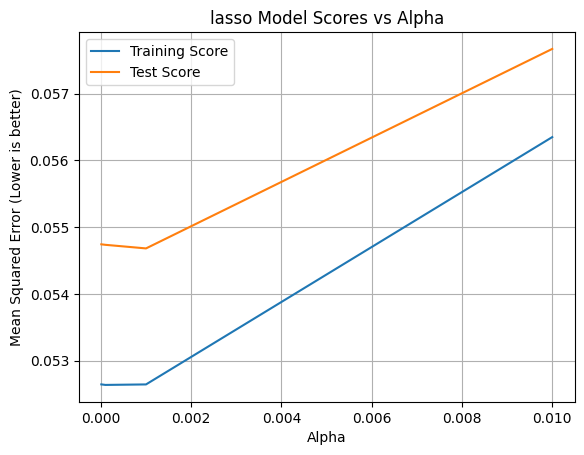

In [604]:
lasso_model.Plot_alpha_vs_mean_scores(skip=-28)

alpha of 0.001

In [605]:
beta_coefficients = pd.DataFrame(index=X_train_rfe_new.columns)
beta_coefficients.rows = X_train_rfe_new.columns
beta_coefficients['Lasso (alpha=0.001)'] = lasso_model.coef_

In [606]:
beta_coefficients.sort_values(by=['Lasso (alpha=0.001)'], ascending=False)

,Lasso (alpha=0.001)
FullBath,0.042942
TotalBsmtSF,0.036017
HalfBath,0.026299
Fireplaces,0.022684
CentralAir,0.019398
Foundation,0.016243
SaleCondition,0.014729
PavedDrive,0.013354
WoodDeckSF,0.013101
BsmtFinSF1,0.011452
